# Clustering - Basics and Algorithms - Part 1
---

:: DETAILED GUIDE TO CLUSTERING ::

https://www.wikiwand.com/en/Cluster_analysis#Connectivity-based_clustering_(hierarchical_clustering)


---

## Contents


1. Principal Component Analysis:
    - 1.1. PCA By Hand
    - 1.2. PCA using model


2. Partitional Clustering:
    - 2.1. K-Means By Hand
    - 2.2. K-Means Using model
  
  
3. Hirerachial Clustering
    - 3.1. Agglomerative
    - 3.2. Divisive Clustering
 
 
4. Density-based Clustering
    - 4.1. DBSCAN
    - 4.2. HDBSCAN
    
    
5. Clustering for Categorical Data

6. Clustering for Mixed Data

7. Clustering for Textual Data
---

# 1. PCA

## Intution

When there are large number of features which may be correlated with each other (pair-plot), principal components analysis (PCA) allows us to summarize this set with a smaller number of representative variables that collectively explain **most of the variability** in the original set.


*Principal components analysis (PCA)* refers to the process by which principal components are computed, and the subsequent use of these components in understanding the data. PCA is an unsupervised approach, since it involves only a set of features $X1, X2,...,Xp$, and no associated response $Y$. 

Apart from producing derived variables for use in supervised learning problems, PCA also serves as a tool for data visualization (visualization of the observations or visualization of the variables). It can also be used as a tool for data imputation — that is, for filling in missing values in a data matrix.

more: https://docs.google.com/document/d/142kUUYeWfDQIH6ymDImeHxCnSP1fk_Gx6Wu-E9Vsbm4/edit#

*min_number_of_components* = min(nrows-1, nfeatures)

--- 

## Imports

In [3]:
import os, sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, ticker as ticker
import seaborn as sns
import warnings
pd.set_option("display.max_columns", 80)
sns.set_style("whitegrid")
sns.set_palette('inferno')
warnings.filterwarnings('ignore')
%matplotlib inline

## Dataset

In [4]:
data = pd.read_csv("data/data_IRIS.csv")

# ignoring labels for now
df = data[data.columns[data.columns!='species']]
df

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## Very Basic EDA

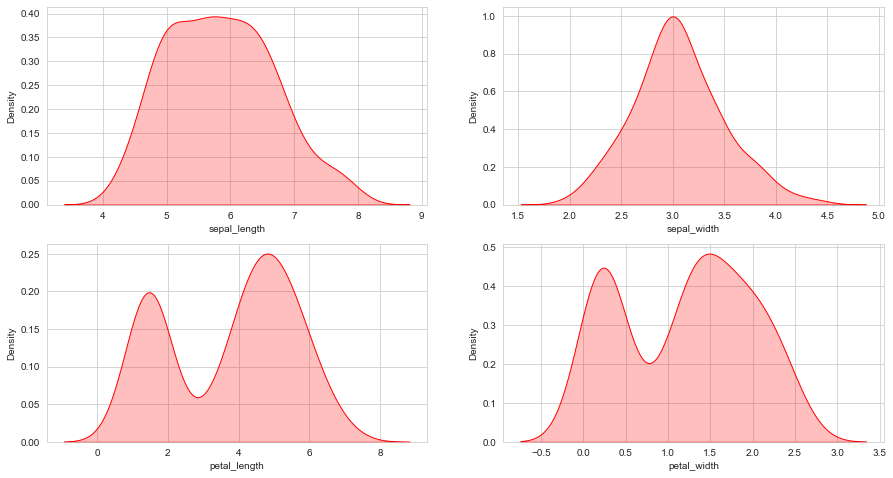

In [5]:
# Density Plots

f, axes = plt.subplots(2, 2, figsize=(15,8), squeeze=False)
nrow, ncol = 0,0
for i, col in enumerate(df.columns):
    if i==2:
        nrow, ncol = nrow+1, 0
    sns.kdeplot(df[col], shade=True, color="r", ax=axes[nrow,ncol])
    ncol+=1

- All exhibit bi-modal distributions, apart from width which looks uncannily perfect.

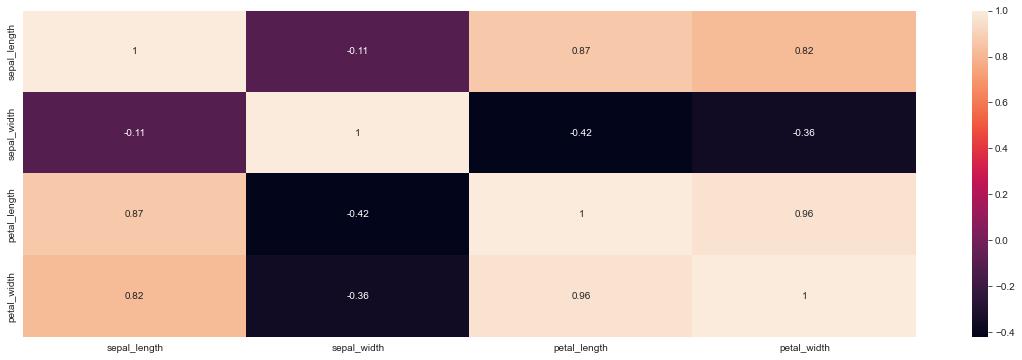

In [6]:
# Heatmap for Correlation Matrix

fig, ax = plt.subplots(figsize=(20,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

- Most of the features are correlated with each other, which is a good test for modelling non-regression models.

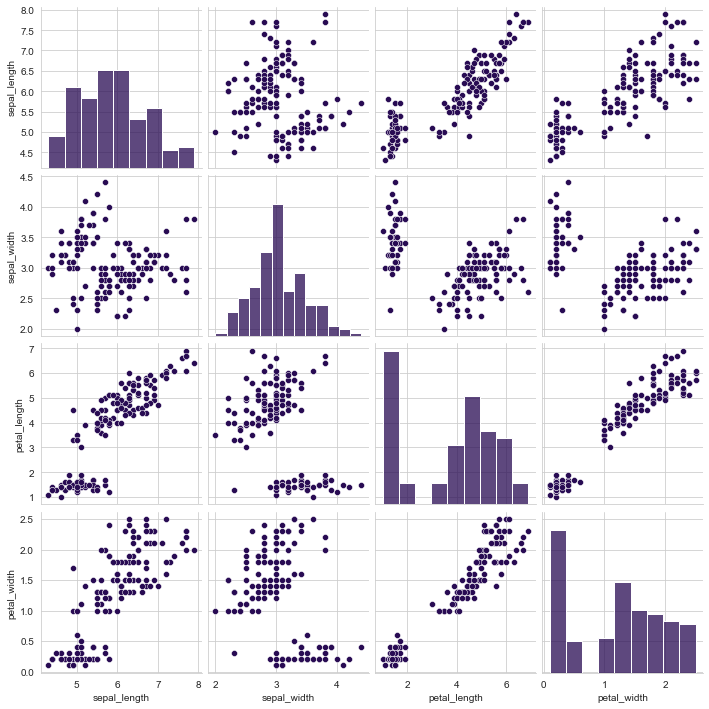

In [7]:
sns.pairplot(df, palette='inferno')

---

## 1.1. PCA by hand

In [8]:
X = df[:]

# number of samples/observations
n = X.shape[0]

# number of features
p = X.shape[1]

n, p

(150, 4)

### 1. Standardize data (bring values to center with squished variance)

$Pandas$ : Uses unbiased estimator of standard deviation, control using `ddof`

$\sigma = \sqrt{\frac{(x - \mu)^2}{N-1}}$


$Numpy$ : Uses biased estimator by default, control using `ddof`

$\sigma = \sqrt{\frac{(x - \mu)^2}{N}}$


$StandardScaler$ : Uses biased estimator by default

$\sigma = \sqrt{\frac{(x - \mu)^2}{N}}$

In [9]:
X_std = (X - X.mean())/np.std(X)

# OR, X_std = (X - X.mean())/X.std(ddof=0)
# OR, X_std = StandardScaler().fit_transform(X)

In [ ]:

# Covariance Matrix
cov_matrix = np.dot(X_std.T, X_std) / (n-1)


 def compute_weight_matrix(self, eig_pairs, cum_var_exp):
    """
    compute weight matrix of top principal components conditioned on target
    explained variance.
    (Hint : use cumilative explained variance and target_explained_variance to find
    top components)

    :param eig_pairs: list of tuples containing eigenvalues and eigenvectors, 
    sorted by eigenvalues in descending order (the biggest eigenvalue and corresponding eigenvectors first).
    :param cum_var_exp: cumulative expalined variance by features
    :return: weight matrix (the shape of the weight matrix is n X k)
    """
    matrix_w = np.ones((self.feature_size, 1))
    for i in range(len(eig_pairs)):
        if cum_var_exp[i] < self.target_explained_variance:
            matrix_w = np.hstack((matrix_w,
                                  eig_pairs[i][1].reshape(self.feature_size,
                                                          1)))
    return np.delete(matrix_w, [0], axis=1).tolist()

### 2. Find the covariance matrix


$Cov (X) = \frac{1}{n-1} (X^T.X)$

Can use: X_std.corr()

In [15]:
cov_matrix = np.dot(X_std.T, X_std) / (n-1)

# OR, (X_std - np.mean(X_std, axis=0)).T.dot((X_std - np.mean(X_std, axis=0))) / (X_std.shape[0] - 1)

# dimensions of cov_matrix will be p x p
cov_matrix

array([[ 1.00671141, -0.11010327,  0.87760486,  0.82344326],
       [-0.11010327,  1.00671141, -0.42333835, -0.358937  ],
       [ 0.87760486, -0.42333835,  1.00671141,  0.96921855],
       [ 0.82344326, -0.358937  ,  0.96921855,  1.00671141]])

### 3. Compute Eigen Pairs using Decomposition method

$ Dimension: $ ==> p x p

$\frac{1}{n-1} (X^T.X) \space = \space v\lambda v^T $


$Eigenvalues = \left(\begin{matrix} \varepsilon_{1} && \varepsilon_{2} && \varepsilon_{2} && \cdots & \varepsilon_{p} \end{matrix}\right)$


$Eigenvectors = \left(\begin{matrix} \hat \varepsilon_{1, 1} & \hat \varepsilon_{1, 2} & \hat \varepsilon_{1, 3} && \cdots & \hat\varepsilon_{1, p} \\ \hat \varepsilon_{2, 1} & \hat \varepsilon_{2, 2} & \hat \varepsilon_{2, 3} && \cdots & \hat \varepsilon_{2, p} \\ \hat \vdots & \vdots & \hat \ddots && \vdots \\ \hat \varepsilon_{p, 1} & \hat \varepsilon_{p, 2} & \hat \varepsilon_{p, 3} && \cdots & \hat \varepsilon_{p, p} \\ \end{matrix}\right)$


$Eigenpairs = \left(\begin{matrix} \varepsilon_{1} [\hat \varepsilon_{1, 1} .. \hat \varepsilon_{p, 1}] & \varepsilon_{2} [\hat \varepsilon_{1, 2} .. \hat \varepsilon_{p, 2}] && \cdots & \varepsilon_{p} [\hat \varepsilon_{1, p} .. \hat \varepsilon_{p, p}] \end{matrix}\right)$


$Final \space  Eigenpairs \space  = \space SORTED_{Descending} \space (Eigenpairs)$

In [9]:
# found using: np.linalg.eig(covariance_matrix)
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

# OR, found using: np.linalg.svd(covariance_matrix)
# u,s,v = np.linalg.svd(cov_matrix)
# eig_values1, eig_vectors1 = s, u

eig_values, eig_vectors

(array([2.93035378, 0.92740362, 0.14834223, 0.02074601]),
 array([[ 0.52237162, -0.37231836, -0.72101681,  0.26199559],
        [-0.26335492, -0.92555649,  0.24203288, -0.12413481],
        [ 0.58125401, -0.02109478,  0.14089226, -0.80115427],
        [ 0.56561105, -0.06541577,  0.6338014 ,  0.52354627]]))

In [10]:
# Eigen Pairs (p x p)

# Along axis=0, i.e. columns
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
eig_pairs = sorted(eig_pairs, reverse=True)

### 4. Compute Proportion of Explained Variation (PVE)


$PVE \space = Sorted \space List \space of (\space \frac{Eigenvalues}{Sum \space of \space Eigenvalues)})$


[0.7277045209380134, 0.2303052326768065, 0.03683831957627366, 0.005151926808906475]
[0.72770452 0.95800975 0.99484807 1.        ]


Text(0.5, 0, 'Principal Components (Dimensions)')

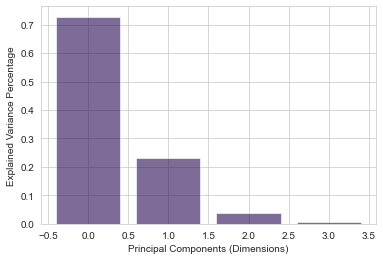

In [11]:
# total explained variance is sorted order of average eigenvalues, 
# the largest becomes the PC1-EValue, and so on.

explained_variance = np.array(eig_values)/sum(eig_values)
explained_variance = sorted(explained_variance, reverse=True)
print(explained_variance)

cum_exp_variance = np.cumsum(explained_variance)
print(cum_exp_variance)

# plotting explained variance for each dimension (PC)

plt.figure(figsize=(6,4))
plt.bar(range(4), explained_variance, alpha=0.6)
plt.ylabel('Explained Variance Percentage')
plt.xlabel('Principal Components (Dimensions)')

### 5. Compute loader_vectors Matrix:


$Z_i = \phi_{1,1}X_1 + \phi_{2,1}X_2 + \phi_{3,1}X_3 + ... + \phi_{p,1}X_p \space = \space np.dot(X_{std}, Eigenvector-Matrix)$


- $PC_1 = \phi_{1,1}X_1 + \phi_{2,1}X_2 + \phi_{3,1}X_3 + ... + \phi_{p,1}X_p$


- $PC_2 = \phi_{1,2}X_1 + \phi_{2,2}X_2 + \phi_{3,2}X_3 + ... + \phi_{p,2}X_p$




In [4]:
import numpy as np

In [6]:
np.array([[1, 2, 3], [4,5,6]]).reshape(-1,1)

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [12]:
# Target Threshold
#   - a simple threshold to decide how many EigenPairs we wish to consider!
#     a 0.999 value means, we wish to see how many EigenPairs it takes to exlain 99.9% variability in the data,
#     it could be two, three or all the EigenPairs, where total EigenPairs = min(n-1, p)
target_explained_variance = 0.99


# Compute all components that explain target:
list_of_principal_eigenpairs = []

for i, eigenpair in enumerate(eig_pairs):
    # If the EigenPairs have reached the target explanation needed 
    # ---> reveals how many EigenPairs we need to explain target % variance
    if cum_exp_variance[i] < target_explained_variance:
        list_of_principal_eigenpairs.append(eigenpair[1])


# *only* for building a weight matrix 
principal_components = np.array(list_of_principal_eigenpairs).T.tolist()

print("\nNumber of Principal Components explaining '{}' % variability in data : {}\n"\
      .format(target_explained_variance, len(principal_components[0])))


Number of Principal Components explaining '0.99' % variability in data : 2



### 6. Compute `p` PCs


$Z_i = \phi_{1,1}X_1 + \phi_{2,1}X_2 + .. + \phi_{p,1}X_p \space = \space np.dot(X_{std}, Eigenvector-Matrix)$

In [13]:
PC_data = X_std.dot(principal_components)
PC_data.columns = ["PC %d" % i for i in range(len(principal_components[0]))]
PC_data

,PC 0,PC 1
0,-2.264542,-0.505704
1,-2.086426,0.655405
2,-2.367950,0.318477
3,-2.304197,0.575368
4,-2.388777,-0.674767
...,...,...
145,1.870522,-0.382822
146,1.558492,0.905314
147,1.520845,-0.266795
148,1.376391,-1.016362


In [14]:
# Onc class to rule it all:

class PCA_hand:
    
    def __init__(self, target_variance=0.95):
        """
        :param target_variance: float, The target level of explained variance
        """
        self.target_explained_variance = target_variance

    def standardize_features(self, X):
        """
        - Standardize features
        :param X: Input data with shape n (# of observations) X p (# of features)
        :return: standardized features
        """
        self.n = X.shape[0]    # number of samples
        self.p = X.shape[1]    # number of features
        return (X - X.mean())/np.std(X)

    def compute_covariance_matrix(self, X_std):
        """
        - Covariance Matrix (X^T.X)/n-1
        :param X_std: standardized features with shape n (# of observations) X p (# of features)
        :return: covariance_matrix
        """
        covariance_matrix = X_std.T.dot(X_std)/(n - 1)
        return covariance_matrix

    def compute_eigen_pairs(self, cov_matrix):
        """
        - Computation of eigenvector, eigenvalues, and eigenpairs in sorted order
        :param cov_matrix: p (# of features) x p (# of features) cov(x_i, x_j)
        :return: eig_values, eig_vectors, eig_pairs
        """
        eig_values, eig_vectors = np.linalg.eig(cov_matrix)

        # Eigen Pairs (p x p): along axis=0, i.e. columns
        eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
        eig_pairs = sorted(eig_pairs, reverse=True)
        return eig_values, eig_vectors, eig_pairs

    def compute_explained_variance(self, eig_values):
        """
        - Compute cumulative explained variance attributed to each of  the principal components.
        :param eig_values: p x 1 matrix containing sorted eigen values (largest to smallest)
        :return: cum_exp_variance
        """
        explained_variance = np.array(eig_values)/sum(eig_values)
        explained_variance = sorted(explained_variance, reverse=True)
        cum_exp_variance = np.cumsum(explained_variance)
        return explained_variance, cum_exp_variance

    def compute_top_components(self, eigen_pairs, cum_exp_variance):
        """
        - Compute a weight matrix for top principal components conditioned on target explained variance.
        :param eigen_pairs: list of tuples containing eigenvalues and eigenvectors,
        :param cum_exp_variance: cumulative expalined variance by features
        :return: weight matrix p x k; where k is number of components able to explain target variance
        """
        list_of_principal_eigenpairs = []
        for i, eigenpair in enumerate(eigen_pairs):
            if cum_exp_variance[i] < self.target_explained_variance:
                list_of_principal_eigenpairs.append(eigenpair[1])
        # *only* for building a weight matrix 
        principal_components = np.array(list_of_principal_eigenpairs).T.tolist()
        print("\nNumber of Principal Components explaining '{}' % variability in data : {}\n"\
              .format(self.target_explained_variance, len(principal_components[0])))
        return principal_components

    def transform(self, X_std, pc_matrix):
        """
        - Transforms data to subspace using principal components matrix
        :param X_std: standardized features
        :param pc_matrix: top principal components
        :return: pc_data
        """
        pc_data = pd.DataFrame(X_std.dot(pc_matrix))
        pc_data.columns = ["PC %d" % i for i in range(len(pc_matrix[0]))]
        return pc_data

    def fit(self, X):
        """    
        - Execute
        :param X: Input data with shape n (# of observations) X p (# of features)
        :return pc_matrix: n x k dimension
        """
        X_std = self.standardize_features(X)
        cov_matrix = self.compute_covariance_matrix(X_std)
        eigen_values, eigen_vectors, eigen_pairs = self.compute_eigen_pairs(cov_matrix)
        explained_variance, cum_exp_variance = self.compute_explained_variance(eigen_values)
        
        # top components matrix of n x k
        principal_components = self.compute_top_components(eigen_pairs, cum_exp_variance)
        
        pc_matrix = self.transform(X_std, principal_components)
        return pc_matrix



# SAMPLE EXECUTION
# pca_obj = PCA_hand(0.99)
# pca_matrix = pca_obj.fit(feature_data)

---

## 1.2. PCA using model

In [15]:
# feature dataset
X = df[:]

X_std = StandardScaler().fit_transform(X)

pca = PCA()
result = pca.fit_transform(X_std)
pca_matrix = pd.DataFrame(result)

# some PCs
pc1 = pca_matrix[0]
pc2 = pca_matrix[1]

pca_matrix

,0,1,2,3
0,-2.264542,0.505704,-0.121943,-0.023073
1,-2.086426,-0.655405,-0.227251,-0.103208
2,-2.367950,-0.318477,0.051480,-0.027825
3,-2.304197,-0.575368,0.098860,0.066311
4,-2.388777,0.674767,0.021428,0.037397
...,...,...,...,...
145,1.870522,0.382822,0.254532,-0.388890
146,1.558492,-0.905314,-0.025382,-0.221322
147,1.520845,0.266795,0.179277,-0.118903
148,1.376391,1.016362,0.931405,-0.024146


Text(0.5, 0, 'Principal Components (Dimensions)')

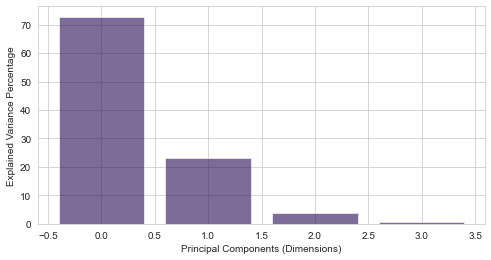

In [16]:
# plotting explained variance for each dimension (PC)

plt.figure(figsize=(8,4))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_*100.0, alpha=0.6)
plt.ylabel('Explained Variance Percentage')
plt.xlabel('Principal Components (Dimensions)')

----
----

# 2. Partitional Clustering

## K-Means

`Algorithm`

- Step 1. Choose the number of clusters (k)


- Step 2. Choose initial centorids using one of the methods below:
    - 2.1. $Random$ - randomly select k data-points as centroids
    - 2.2. $kmeans++$ - Based on heuristics, assign some imaginary points as centroids.
    - 2.3. $User-defined$ - User chooses the inital centroids based on judgement.
    
    
- Step 3. Compute pair-wise distance matrix, using Euclidean Distance, $Ed(X_{11}, X_{12})$ 


- Step 4. Sort the proximity matrix and choose smallest distances and assign them the centroid's cluster ids.


- Step 5. Updated centroids: Recompute the centroid coordinates for all the members including newer cluster-ids created.


- Step 6. Repeat 3, 4 and 5 till either of the two conditions are met:
    - 6.1. Till the model converges and there are no new centroids being created, or,
    - 6.2. The process limits to the number of max-iterations defined.
    

- Done.


The quality of the cluster assignments is determined by computing the sum of the squared error (SSE) after the centroids converge, or match the previous iteration’s assignment. The SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid. Since this is a measure of error, the objective of k-means is to try to minimize this value.

The random initialization step causes the k-means algorithm to be nondeterministic, meaning that cluster assignments will vary if you run the same algorithm twice on the same dataset. Researchers commonly run several initializations of the entire k-means algorithm and choose the cluster assignments from the initialization with the lowest SSE.

## Imports

In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

## Data

In [3]:
data = pd.DataFrame({"UID": ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9'],
                   "X": [3,5,6,2,7,2,4,3,5], 
                   "Y": [9,7,4,8,3,6,3,8,8]})

df = data[:]
df.set_index('UID', inplace=True)
df

,X,Y
UID,,
A1,3,9
A2,5,7
A3,6,4
A4,2,8
A5,7,3
A6,2,6
A7,4,3
A8,3,8
A9,5,8


## Very Basic EDA

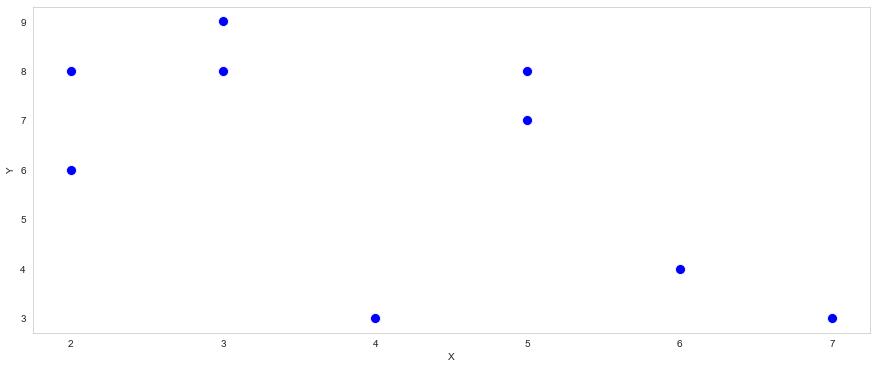

In [4]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(x=df.X, y=df.Y, marker="o", color='blue', s=100)

- Clearly three to four clusters

## Normalization

K-Means uses euclidean distance which makes squishing the values on a similar scale essential, else with squared distances, vectors with a higher magnitude will distort the cluster centers

In [5]:
# The dummy data was created by hand, and hence requires no normalization as such

----

## 2.1. K-Means by Hand

### 1. Set parameters

In [6]:
def get_plot(data):
    """Plotting Points"""
    cluster_col = 'Cluster_id'
    # get n clusters
    cluster_ids = data[cluster_col].unique()
    # get n colors
    colors = ["#%06x" % random.randint(0, 0xFFFFFF) for i in range(len(cluster_ids))]
    # assign each cluster as some colour
    fig, ax = plt.subplots(figsize=(15,6))
    for i in cluster_ids:
        sample = data[data[cluster_col] == i]
        plt.scatter(sample["X"], sample["Y"], c=colors[i], s=100)
    # color centroid
    plt.scatter(data['Centroid_X'], data['Centroid_Y'], c='black', marker="+", linewidths=10, s=300)
    plt.xlabel('X coord')
    plt.ylabel('Y coord')
    plt.show()
    return

In [7]:
# :: configuration ::

N_CLUSTER_K = 4
SAMPLE_SIZE = len(df)
KMEANS_RATE = 5

# inits
df['Cluster_id'] = -1
df['Centroid_X'] = None
df['Centroid_Y'] = None
df

,X,Y,Cluster_id,Centroid_X,Centroid_Y
UID,,,,,
A1,3,9,-1,None,None
A2,5,7,-1,None,None
A3,6,4,-1,None,None
A4,2,8,-1,None,None
A5,7,3,-1,None,None
A6,2,6,-1,None,None
A7,4,3,-1,None,None
A8,3,8,-1,None,None
A9,5,8,-1,None,None


### 2. Choose initial centroids (random, kmeans++, etc)

In [8]:
random.seed(7)
unique_ids = df.index.tolist()

# 1. method = 'random' from dataset
INITIAL_CENTROIDS = []
INITIAL_CENTROIDS = random.sample(unique_ids, k=N_CLUSTER_K)

# 2. OR, method = 'user choice' from dataset
# INITIAL_CENTROIDS = ["A1", "A2", "A3"]

# 3. OR, method = 'random coordinates' based on heuristics
# INITIAL_CENTROIDS = [(2,4), (5,5), (6,6)]

print("Our initial centroids are: ", INITIAL_CENTROIDS)

Our initial centroids are:  ['A6', 'A3', 'A4', 'A9']


### 3. Update Centroid Information

     X  Y  Cluster_id Centroid_X Centroid_Y
UID                                        
A1   3  9          -1       None       None
A2   5  7          -1       None       None
A3   6  4           1          6          4
A4   2  8           2          2          8
A5   7  3          -1       None       None
A6   2  6           0          2          6
A7   4  3          -1       None       None
A8   3  8          -1       None       None
A9   5  8           3          5          8


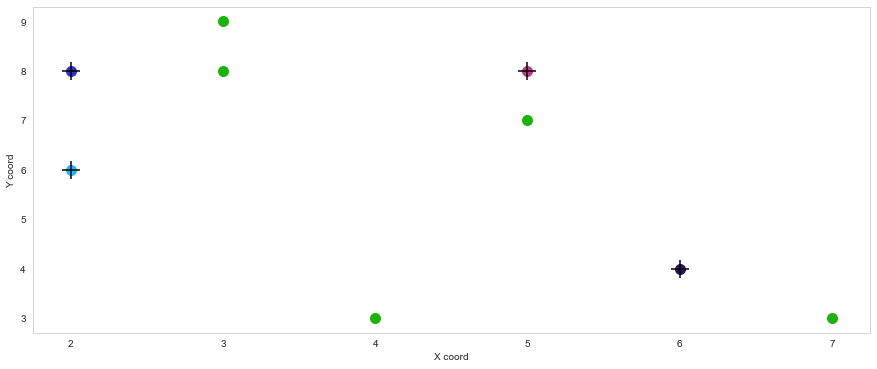

In [9]:
Cluster_id = 0

for uid in INITIAL_CENTROIDS:
    df.loc[uid, "Cluster_id"], df.loc[uid, "Centroid_X"], df.loc[uid, "Centroid_Y"] = \
        Cluster_id, df.loc[uid, "X"], df.loc[uid, "Y"]
    Cluster_id+=1

# store cluster id information (assigned to only centroids for now)
cluster_ids = list(set(df['Cluster_id']))
cluster_ids.remove(-1)

print(df)
get_plot(df)

- `+` are initial chosen centorids

### Iteration 1: 

#### 4.1. Compute relative pair-wise distances for each datapoint

In [10]:
for i, cid in enumerate(cluster_ids):
    
    # Centroid Information
    center_X, center_Y = df[df['Cluster_id'] == cid][['Centroid_X','Centroid_Y']].drop_duplicates().values[0]
    col_name = "dist_cid_{}".format(cid)
    
    # Distance Matrix: d[ Centorid vs Each_data_point ]
    distances = []
    for i, row in df.iterrows():
        # Markowinov distance with p=2 aka Euclidean Distance
        eucliden_distance = np.sqrt((center_X - row['X'])**2 + (center_Y - row['Y'])**2)
        distances.append(eucliden_distance)
    df[col_name] = distances
    
df

,X,Y,Cluster_id,Centroid_X,Centroid_Y,dist_cid_0,dist_cid_1,dist_cid_2,dist_cid_3
UID,,,,,,,,,
A1,3,9,-1,None,None,3.162278,5.830952,1.414214,2.236068
A2,5,7,-1,None,None,3.162278,3.162278,3.162278,1.000000
A3,6,4,1,6,4,4.472136,0.000000,5.656854,4.123106
A4,2,8,2,2,8,2.000000,5.656854,0.000000,3.000000
A5,7,3,-1,None,None,5.830952,1.414214,7.071068,5.385165
A6,2,6,0,2,6,0.000000,4.472136,2.000000,3.605551
A7,4,3,-1,None,None,3.605551,2.236068,5.385165,5.099020
A8,3,8,-1,None,None,2.236068,5.000000,1.000000,2.000000
A9,5,8,3,5,8,3.605551,4.123106,3.000000,0.000000


#### 4.2. Assign smallest distances from centroids as their clusters

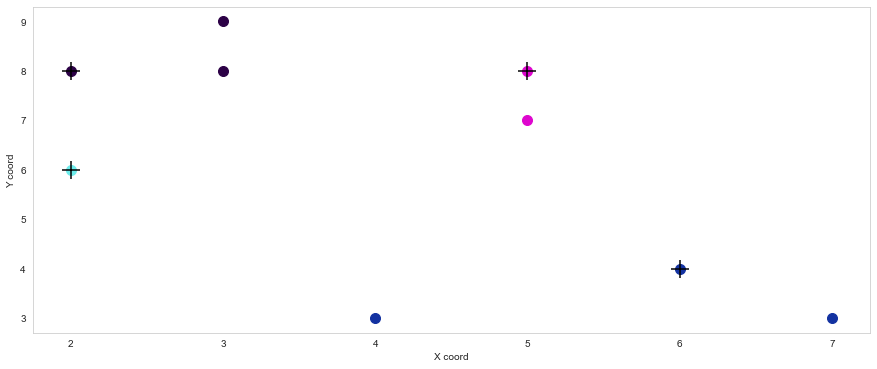

In [11]:
re_computed_ClusterIds = []

for i, row in df.iterrows():
    
    # distance matrix for each row in data
    dist_each_cluster = [row["dist_cid_{}".format(i)] for i in cluster_ids]
    index_min_distance = np.argmin(dist_each_cluster)
    
    # assign min dist cluster_id
    assigned_cluster_id= cluster_ids[index_min_distance]
    re_computed_ClusterIds.append(assigned_cluster_id)
    
# assinging new cluster ids (based on min dist)
df['Cluster_id'] = re_computed_ClusterIds

get_plot(df)

### 5. Update Centorids

In [12]:
### compute new centroids based on cluster-ids

centroid_df = df.groupby(['Cluster_id'])[['X', 'Y']].mean()
centroid_df

,X,Y
Cluster_id,,
0,2.000000,6.000000
1,5.666667,3.333333
2,2.666667,8.333333
3,5.000000,7.500000


In [13]:
new_centroids_X, new_centroids_Y = [], []

for i, row in df.iterrows():
    center_X, center_Y = centroid_df.loc[row['Cluster_id'],:]['X'], centroid_df.loc[row['Cluster_id'],:]['Y']
    new_centroids_X.append(center_X)
    new_centroids_Y.append(center_Y)

df['Centroid_X'] = new_centroids_X
df['Centroid_Y'] = new_centroids_Y

df

,X,Y,Cluster_id,Centroid_X,Centroid_Y,dist_cid_0,dist_cid_1,dist_cid_2,dist_cid_3
UID,,,,,,,,,
A1,3,9,2,2.666667,8.333333,3.162278,5.830952,1.414214,2.236068
A2,5,7,3,5.000000,7.500000,3.162278,3.162278,3.162278,1.000000
A3,6,4,1,5.666667,3.333333,4.472136,0.000000,5.656854,4.123106
A4,2,8,2,2.666667,8.333333,2.000000,5.656854,0.000000,3.000000
A5,7,3,1,5.666667,3.333333,5.830952,1.414214,7.071068,5.385165
A6,2,6,0,2.000000,6.000000,0.000000,4.472136,2.000000,3.605551
A7,4,3,1,5.666667,3.333333,3.605551,2.236068,5.385165,5.099020
A8,3,8,2,2.666667,8.333333,2.236068,5.000000,1.000000,2.000000
A9,5,8,3,5.000000,7.500000,3.605551,4.123106,3.000000,0.000000


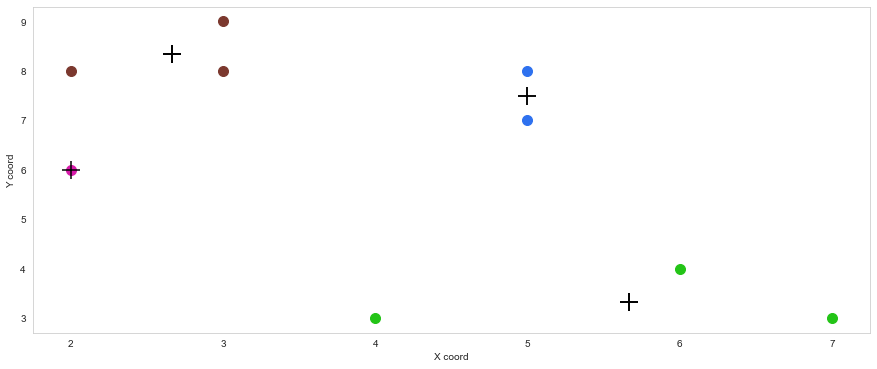

In [14]:
get_plot(df)

In [15]:
# for computing SSE between centorids

iteration1_centroid_df = centroid_df[:]

### Iteration 2: 

Should we stop or continue ?

*- put a limit of max_iterations or a check if no centroids are updated exit the process.*

#### 6.1. Compute relative pair-wise distances for each datapoint

In [421]:
for i, cid in enumerate(cluster_ids):
    
    # Centroid Information
    center_X, center_Y = df[df['Cluster_id'] == cid][['Centroid_X','Centroid_Y']].drop_duplicates().values[0]
    col_name = "dist_cid_{}".format(cid)
    
    # Distance Matrix: d[ Centorid vs Each_data_point ]
    distances = []
    for i, row in df.iterrows():
        # Markowinov distance with p=2 aka Euclidean Distance
        eucliden_distance = np.sqrt((center_X - row['X'])**2 + (center_Y - row['Y'])**2)
        distances.append(eucliden_distance)
    
    df[col_name] = distances
    
df

,X,Y,Cluster_id,Centroid_X,Centroid_Y,dist_cid_0,dist_cid_1,dist_cid_2,dist_cid_3
UID,,,,,,,,,
A1,3,9,2,2.666667,8.333333,3.162278,6.262765,0.745356,2.500000
A2,5,7,3,5.000000,7.500000,3.162278,3.726780,2.687419,0.500000
A3,6,4,1,5.666667,3.333333,4.472136,0.745356,5.467073,3.640055
A4,2,8,2,2.666667,8.333333,2.000000,5.934831,0.745356,3.041381
A5,7,3,1,5.666667,3.333333,5.830952,1.374369,6.871843,4.924429
A6,2,6,0,2.000000,6.000000,0.000000,4.533824,2.426703,3.354102
A7,4,3,1,5.666667,3.333333,3.605551,1.699673,5.497474,4.609772
A8,3,8,2,2.666667,8.333333,2.236068,5.374838,0.471405,2.061553
A9,5,8,3,5.000000,7.500000,3.605551,4.714045,2.357023,0.500000


#### 6.2. Assign smallest distances from centroids as their clusters

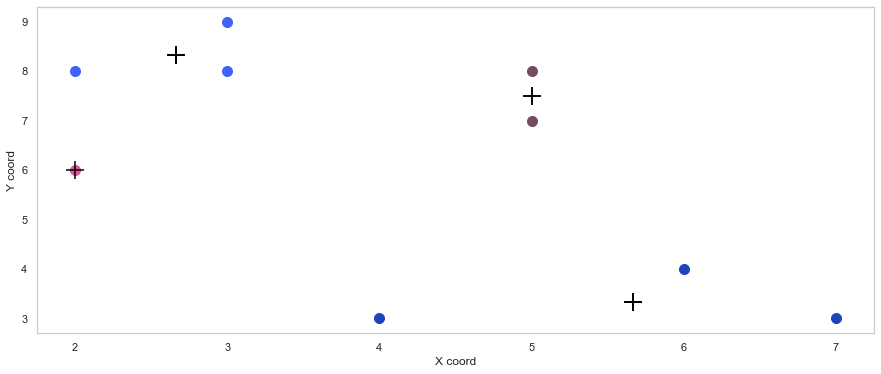

In [422]:
re_computed_ClusterIds = []

for i, row in df.iterrows():
    
    # distance matrix for each row in data
    dist_each_cluster = [row["dist_cid_{}".format(i)] for i in cluster_ids]
    index_min_distance = np.argmin(dist_each_cluster)
    
    # assign min dist cluster_id
    assigned_cluster_id= cluster_ids[index_min_distance]
    re_computed_ClusterIds.append(assigned_cluster_id)
    
# assinging new cluster ids (based on min dist)
df['Cluster_id'] = re_computed_ClusterIds
get_plot(df)

- No change in cluster members, we have reached an impass!
- Exit process.

In [423]:
# for computing SSE between centorids

iteration2_centroid_df = centroid_df[:]

### Should we stop?

In [424]:
# sum_distances_centroid

(iteration2_centroid_df - iteration1_centroid_df).agg(['sum']).sum(axis=1)[0]

0.0

- Voila!
- We can try one more stop to see if centroid changes (it won't here, but for larger datasts, it will take time to converge on suitable centorids)

### Iteration 3

In [426]:
# perform another iteration:
# 1. Compute distances between each point and centroids
# 2. Find centorid with min distance 
# 3. Assign centorid's cluster id to the data point
# 4. Recompute centorid information comprising of newly added memebers

- Centroids do not change, hence we can stop.
- We have acquired best centroid distributions. Is it?

- We can perform this process iteratively, 'n' times with random allocation of intial centorids (kmeans++), to validate if this actually was the best inital segmentation.

----

#### Iterative K-Means for 2-Dimensional data (ONLY) : One class to rule it all!

In [445]:
class K_Means:
    """ Iterative KMeans Clustering """
    
    def __init__(self, MAX_ITERS, 
                 KMEANS_RATE, 
                 CLUSTER_K=None, 
                 COHESION_THRESHOLD=0.1, 
                 N_CROSS_VALIDATE = 3,
                 SCALING=True,
                 col_UID=None, col_feature_1="X", col_feature_2="Y", col_cluster_id="Cluster_id"):
        
        # clustering params settings
        self.max_iters = MAX_ITERS                     # max number of times each clustering process can run
        self.kmeans_rate = KMEANS_RATE                 # learning rate
        self.cluster_k = CLUSTER_K                     # user-defined or statisitc based computed
        self.scaling = SCALING                         # standardize or not
        self.cohesion_threshold = COHESION_THRESHOLD   # threshold value for diff b/w two sum(centroids)
        self.cv = N_CROSS_VALIDATE                     # iterative clustering number of times
        
        # data feature names
        self.UID = col_UID
        self.orginal_X = col_feature_1
        self.orginal_Y = col_feature_2
        self.centroid_X = 'Centroid_X'
        self.centroid_Y = 'Centroid_Y'
        self.cluster_id = col_cluster_id
        
        if self.scaling:
            self.scaler = StandardScaler()
            self.X = "Scaled_%s" % self.orginal_X
            self.Y = "Scaled_%s" % self.orginal_Y
        else:
            self.X = self.orginal_X
            self.Y = self.orginal_Y
        
        self.df = {}
        self.centroid_df = {}   
        self.distance_matrix = {}
        return
        
    
    def prepare_df(self, data):
        """
        Takes a new dataset and processes it.
        """
        if not self.UID: 
            self.UID = ["UID_%d" % i for i in range(len(data))]
        data = data.drop_duplicates(subset=[self.orginal_X, self.orginal_Y]).reset_index(drop=True)
        if not self.cluster_k:
            self.cluster_k = int(np.sqrt(len(data) / 2)) * self.kmeans_rate
        data[self.cluster_id] = -1
        data[self.centroid_X] = 0
        data[self.centroid_Y] = 0
        if self.scaling:
            self.scaler.fit(data[[self.orginal_X, self.orginal_Y]])
            data[self.X], data[self.Y] = zip(*self.scaler.transform(data[[self.orginal_X, self.orginal_Y]]))
        return data
        
    
    def init_centroids(self):
        """
        Randomly allocated few datapoints as centroids.
        """
        # Select random observation as centroids
        candidates = self.df[self.UID].tolist()
        
        INITIAL_CENTROIDS = []
        for i in range(self.cluster_k):
            chosen = candidates[np.random.randint(len(candidates))]
            candidates.remove(chosen)
            INITIAL_CENTROIDS.append(chosen)
    
        # Centroid Coordinates
        self.centroid_df = pd.DataFrame({self.cluster_id: range(self.cluster_k),
                                         self.X: self.df[self.df[self.UID].isin(INITIAL_CENTROIDS)][self.X],
                                         self.Y: self.df[self.df[self.UID].isin(INITIAL_CENTROIDS)][self.Y]})
        self.centroid_df = self.centroid_df.reset_index(drop=True)
        print("centroids initialized with: ", INITIAL_CENTROIDS)        
        
    
    def calc_sse(self):
        """
        Computes sum of squared errors for each clustered matrix.
        """
        # SSE = SUM[ dist(closest_centorid, point) ]
        return self.distance_matrix['dist_min'].sum()

    
    def calc_distance_matrix(self):
        """
        Computes distance matrix between centroids vs rest of data-points.
        
         X,Y        Centroid_1(X,Y)   Centroid_2(X,Y)   Centroid_3(X,Y)     min_dist    assigned_cluster
        Point_1      d(c1, p1)           d(c2, p1)         d(c3, p1)          min_d        c1
        Point_2      d(c1, p2)           d(c2, p2)         d(c3, p2)          min_d        c2
        Point_3      d(c1, p3)           d(c2, p3)         d(c3, p3)          min_d        c3
        
        """
        ### assign closest centroids and set cluster_ids
        self.distance_matrix = {}
        for i, center_coord in self.centroid_df.iterrows():

            # cal distance b/w Centroid vs rest points
            dist_dict = {}
            for i, sample_coord in self.df.iterrows():
                # distance metric: euclidean distance
                dist = np.sqrt((center_coord[self.X] - sample_coord[self.X])**2 + \
                               (center_coord[self.Y] - sample_coord[self.Y])**2)
                dist_dict.update({sample_coord[self.UID]: dist}) 
            
            self.distance_matrix[int(center_coord[self.cluster_id])] = dist_dict
        
        # final dist matrix 
        self.distance_matrix = pd.DataFrame(self.distance_matrix)
        return

    
    def find_closest_centroids(self):
        """
        Based on dist matrix, identifies closest centroid to each datapoint.
        """
        # reshape dist matrix
        self.distance_matrix = pd.DataFrame(self.distance_matrix)
        self.distance_matrix[[self.cluster_id, 'dist_min']] = self.distance_matrix.agg(['idxmin', 'min'], axis=1)
        self.distance_matrix[self.cluster_id] = self.distance_matrix[self.cluster_id].astype(int)
        # SSE = sum of min_distances_to_each_centroid
        SSE = self.distance_matrix['dist_min'].sum()
        return SSE
        
    
    def assign_centroids(self):
        """
        Using `find_closest_centroids()`, assigns each datapoint to a centroid (aka. cluster-id)
        """
        # assign cluster id to original dataset
        uid_cluster_map = self.distance_matrix[self.cluster_id].to_dict()
        self.df[self.cluster_id] = self.df[self.UID].replace(uid_cluster_map)
        self.df[self.centroid_X] = self.df[self.cluster_id].replace(self.centroid_df[[self.cluster_id, self.X]].set_index(self.cluster_id).T.to_dict('records')[0])
        self.df[self.centroid_Y] = self.df[self.cluster_id].replace(self.centroid_df[[self.cluster_id, self.Y]].set_index(self.cluster_id).T.to_dict('records')[0])

    
    def update_centroids(self):
        """
        Computes new centroids X,Y values based on assigned cluster-ids.
        """
        ### compute new centroids based on cluster-ids
        self.centroid_df = self.df.groupby([self.cluster_id])[[self.X, self.Y]].mean().reset_index()
        return
    
    
    def perform_clustering(self, data):
        """
        Performs clustering on a given dataset, using all above modules.
        """
        
        # performs **only** on the user-passed dataset.
        self.df = data[:]
        
        # inits centroids randomly
        self.init_centroids()
        
        counter=0
        for n_iter in range(self.max_iters):
            
            # 1. init centroids
            prev_centroids = self.centroid_df
            
            # 2. cal distances b/w each datapoint and centroids
            self.calc_distance_matrix()
            
            # 3. identifies closest centroids to each data-point
            SSE = self.find_closest_centroids()
            
            # 4. assigns each datapoint a centroid (aka cluster id)
            self.assign_centroids()
            
            # 5. Re-computes new centroid (X,Y) values based on assigned cluster-ids
            self.update_centroids()
            active_centroids = self.centroid_df
            
            # 6. Comparison b/w previous centroid data and new centroid data to detect for a change
            centroid_delta = abs((active_centroids - prev_centroids).agg(['sum']).sum(axis=1)[0])
            print("{}. Iteration #{} | SSE {} | Centroid_Delta {}".format(counter, n_iter, SSE, centroid_delta))
            
            # **break** if centroids data didn't change!
            if centroid_delta <= self.cohesion_threshold:
                print("centroid update halted, clustering complete.")
                break
            
            counter+=1
        return self.df, SSE
            
    
    def execute(self, data):
        """
        Executes clustering pipeline iteratively for 'CV' times, mainly to detect changes in clusters with 
        varying initial centroid assignments. 
        
        E.g. 
        Iteration 1: assigns initial centroids to A1,A2,A3, --> get final clustered data, final SSE.
        Iteration 2: assigns initial centroids to A4,A5,A6, --> get final clustered data, final SSE.
        Iteration 3: assigns initial centroids to A7,A8,A9, --> get final clustered data, final SSE.
        
        And finds the best clustered data and SSE score.
        """
        
        # prep dataset
        processed_df = self.prepare_df(data)
        
        # n-iterative clustering
        
        # stores list of SSE scores achieved with each iteration
        lst_sse = []
        
        # stores list of final clustered data with each iteration
        clustered_data = []
        
        for cross_validate in range(self.cv):
            
            print("\nClustering... [", cross_validate, "]")
            cluster_df, cluster_SSE = self.perform_clustering(processed_df)
            
            lst_sse.append(cluster_SSE)
            clustered_data.append(cluster_df)
            self.df = {}
        
        # compare various clustered results for best cluster
        # => lst_sse = [0.5, 0.3, 1.2]  ---> idxmin = 1, min = 0.3
        # => clustered_data[idxmin]     ---> best cluster df
        best_iteration, best_sse = pd.Series(lst_sse).agg(['idxmin', 'min'])
        best_clustered_df = clustered_data[int(best_iteration)]
        print("*** BEST CLUSTERING RESULTS ***\nSSE = ", best_sse)
        
        return best_clustered_df

In [442]:
# original dataset
df = data[:]

kmeans = K_Means(MAX_ITERS=10, 
                 KMEANS_RATE=5, 
                 CLUSTER_K=3, 
                 N_CROSS_VALIDATE=10, 
                 SCALING=False, 
                 col_UID="UID", 
                 col_feature_1="X", 
                 col_feature_2="Y")

final = kmeans.execute(df[['UID', "X", 'Y']])


Clustering... [ 0 ]
centroids initialized with:  ['A6', 'A2', 'A7']
0. Iteration #0 | SSE 13.30056307974577 | Centroid_Delta 3.0000000000000004
1. Iteration #1 | SSE 10.647824830316269 | Centroid_Delta 0.0
centroid update halted, clustering complete.

Clustering... [ 1 ]
centroids initialized with:  ['A5', 'A6', 'A1']
0. Iteration #0 | SSE 11.89292222699217 | Centroid_Delta 1.3999999999999995
1. Iteration #1 | SSE 10.306053137947664 | Centroid_Delta 0.0
centroid update halted, clustering complete.

Clustering... [ 2 ]
centroids initialized with:  ['A7', 'A2', 'A6']
0. Iteration #0 | SSE 13.30056307974577 | Centroid_Delta 3.0000000000000004
1. Iteration #1 | SSE 10.647824830316269 | Centroid_Delta 0.0
centroid update halted, clustering complete.

Clustering... [ 3 ]
centroids initialized with:  ['A9', 'A4', 'A2']
0. Iteration #0 | SSE 16.171732803158715 | Centroid_Delta 2.0
1. Iteration #1 | SSE 9.748494495181925 | Centroid_Delta 1.2499999999999996
2. Iteration #2 | SSE 9.1037503684237

In [446]:
final

,UID,X,Y,Cluster_id,Centroid_X,Centroid_Y
0,A1,3,9,1,2.500000,7.750000
1,A2,5,7,2,5.000000,7.500000
2,A3,6,4,0,5.666667,3.333333
3,A4,2,8,1,2.500000,7.750000
4,A5,7,3,0,5.666667,3.333333
5,A6,2,6,1,2.500000,7.750000
6,A7,4,3,0,5.666667,3.333333
7,A8,3,8,1,2.500000,7.750000
8,A9,5,8,2,5.000000,7.500000


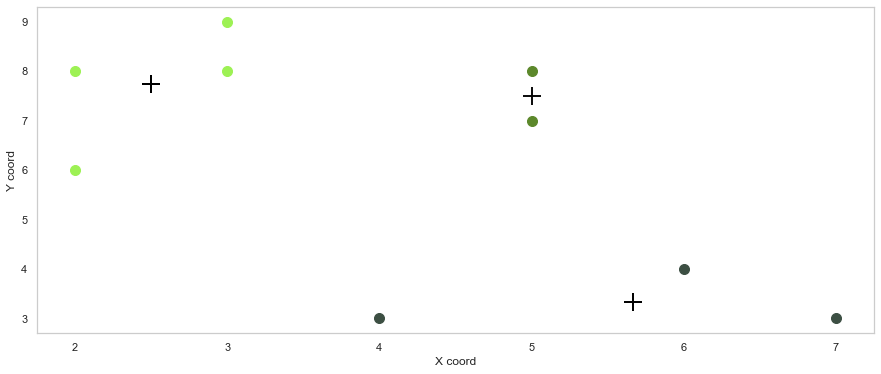

In [447]:
get_plot(final)

Confirmed!


Iterative clustering over ten times, produces a normal dist of SSE, giving us the assumed initial centroid allocation

----

## 2.2. K-Means using sklearn

- Collect data consisting only of numerical feature set
- Noramlize data.
- Find optimal k.
- Visualize clusters using PCA and hue as cluster ids, and, t-SNE.
- Fit the best model

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hic
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [107]:
# load a new dataset consisting of 6 features

df = pd.read_csv("Data/data_numerical_6Features.csv")
print(df.shape)
df.head()

(4000, 6)


,x1,x2,x3,x4,x5,x6
0,1.868873,-10.463549,0.674638,0.912393,-0.003039,-2.202443
1,-0.137840,5.363186,-0.444914,4.125290,0.002185,-6.643935
2,1.051263,-7.977121,-1.926635,1.195411,0.017575,-6.092424
3,1.426620,-10.728448,-0.062891,2.053938,0.001306,-4.519171
4,1.841122,-4.068528,-0.493864,3.354350,-0.014658,4.857383


- Only numerical feature set (no categorical or labels)

### 1. Normalize data

K-Means uses euclidean distance which makes squishing the values on a similar scale essential, else with squared distances, vectors with a higher magnitude will distort the cluster centers


In [108]:
# standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# normalize
norm_data = normalize(scaled_data)

df_scaled = pd.DataFrame(norm_data)
df_scaled.columns = df.columns
df_scaled

,x1,x2,x3,x4,x5,x6
0,0.590843,-0.637630,0.174595,-0.395628,-0.108163,-0.213607
1,-0.044665,0.466394,-0.234247,0.775373,0.080312,-0.343450
2,0.264805,-0.369126,-0.633375,-0.232023,0.515914,-0.269182
3,0.527447,-0.768504,-0.116626,0.034097,0.059383,-0.336022
4,0.585551,-0.186709,-0.261405,0.516079,-0.536189,0.010064
...,...,...,...,...,...,...
3995,0.624885,-0.028211,-0.034420,-0.177925,-0.250167,0.716447
3996,-0.480740,0.188995,0.176555,-0.484903,0.216449,0.648088
3997,-0.454434,0.125315,0.236322,0.171190,0.761901,0.334871
3998,-0.390336,0.091263,0.774678,-0.386411,0.079782,0.288971


### 2. Find the optimal value of `k`

Three approaches could be considered:
- 1. Elbow method
- 2. Silhouette method
- 3. Dendrogram Analysis
- 4. Using AIC And BIC From GMM
- 5. Gap Statistics


Evaluation metrics:
- 'Silhouette'
- 'Calinski_Harabasz',
- 'Davis Bouldin'
- 'Adjusted_Mutual_Info'
- 'Adjusted_Rand_Scores

In [211]:
def evaluate_clusters(X, pred_cluster, target_labels=None):
    """
        One method to compute all clustering evaluation metric scores!
    """
    silhouette = silhouette_score(X, pred_cluster, metric='euclidean')
    cal_har = calinski_harabasz_score(X, pred_cluster)
    dav_bould = davies_bouldin_score(X, pred_cluster)
    adj_mut_info = adjusted_mutual_info_score(target_labels, pred_cluster, average_method='arithmetic')
    adj_rand = adjusted_rand_score(target_labels, pred_cluster)
    content = {'Silhouette':silhouette,
               'Calinski_Harabasz':cal_har,
               'Davis Bouldin':dav_bould,
               'Adjusted_Mutual_Info':adj_mut_info,
               'Adjusted_Rand_Score':adj_rand}
    return content

### Sample
### evaluate_clusters(X, kmeans.fit_predict(X), target_labels=None)

#### 2.1. Elbow Method
- The elbow method is a useful graphical tool to estimate the optimal number of clusters k.


- We can say that, if k increases, the within-cluster SSE (“distortion”) will decrease. This is because the samples will be closer to the centroids they are assigned to. 


- The idea behind the elbow method is to identify the value of k where the distortion begins to decrease most rapidly, which will become clearer if we plot the distortion for different values of k.

In [84]:
def compute_elbow_method(data, min_clusters, max_clusters, random_seed):
    """
    Find optimal number of cluster according to SSE distortion score.
    """
    
    # `distortion` --> within-cluster sum of squared distances for a range of number of cluster
    distortions = []
    
    for k_value in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=k_value, 
                        init='k-means++',     # k-means++ --> heurstics method, random --> sampler based
                        n_init=10, 
                        max_iter=300, 
                        tol=1e-04, 
                        random_state=random_seed)
        kmeans = kmeans.fit(data)

        # Storing distortion: Checking 'k' where the rapid dec and then flattens out!
        distortions.append(kmeans.inertia_)

    # plot
    plt.figure(figsize=(10,6))
    plt.plot(range(min_clusters, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters k')
    plt.ylabel('SSE (aka. Distortion)')
    plt.show()

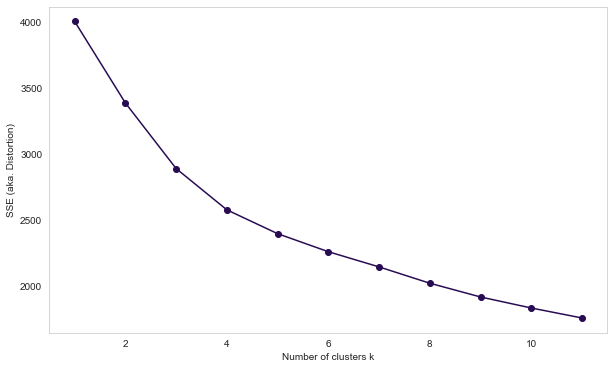

In [85]:
compute_elbow_method(df_scaled, min_clusters=1, max_clusters=12, random_seed=7)

- We can see the flatten out point is either, k=3 or k=4, thus these are the optimal values for n_clusters!

#### 2.2. Silhouette Method

The silhouette score measures how similar a data point is to its own cluster, i.e average distance between its own members - cohesion, and how dissimilar is the point to other cluster members (separation).

- The silhouette ranges from −1 to +1.


- The best value is 1, and a value close to 1 means that the sample’s distance to the nearest neighbor cluster is much larger than the intra-cluster distance.
- 0 indicate overlapping clusters (no average distance is significant).
- The worst value is -1, and a value close to -1 means that the sample is assigned to the wrong cluster.

The Silhouette score of the model is the average Silhouette value of all samples.

In [86]:
def compute_silhouette_method(data, min_clusters, max_clusters, random_seed):
    """
    Find optimal number of cluster according to silhouette score.
    """
    
    silhouette_scores = []
    for k in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=1e-04, 
                        random_state=random_seed)
        kmeans = kmeans.fit(data)
        cluster_labels = kmeans.fit_predict(data) 
        sil_score = silhouette_score(data, cluster_labels)
        silhouette_scores.append([k, sil_score])
    
    # Silhouette Scores Matrix: shape of 'n' clusters vs their respective scores
    # k  silhouette_score
    # 1  0.56
    # 2  0.34
    # ...
    # n  0.22 --> Find max
    silhouette_score_matrix = np.array(silhouette_scores)
    max_score_index = np.argmax(silhouette_score_matrix[:, 1])   # [4,  0.78]
    n_k, max_score = silhouette_score_matrix[max_score_index][0], silhouette_score_matrix[max_score_index][1]
    #print("n_clusters =", int(n_k), "The average silhouette_score is : %.4f" % max_score)
    
    # plot
    plt.figure(figsize=(10,6))
    plt.plot(range(min_clusters, max_clusters), silhouette_score_matrix[:, 1], marker='o')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    return silhouette_score_matrix

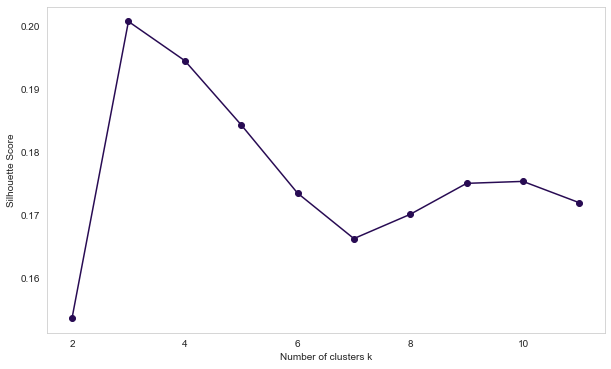

array([[ 2.        ,  0.15358929],
       [ 3.        ,  0.2007618 ],
       [ 4.        ,  0.19452581],
       [ 5.        ,  0.18432073],
       [ 6.        ,  0.17345904],
       [ 7.        ,  0.16621806],
       [ 8.        ,  0.17008109],
       [ 9.        ,  0.17500676],
       [10.        ,  0.17531939],
       [11.        ,  0.17192447]])

In [87]:
compute_silhouette_method(df_scaled, min_clusters=2, max_clusters=12, random_seed=7)

- Average Silhouette score are maximum when number of clusters are 3 and then 4

####  2.3. Deciding Number Of Clusters Using Hierarchical Dendrogram

In [67]:
def compute_dendrogram(X, linkage='ward'):
    plt.figure(figsize=(16,8))
    distance_matrix = hic.linkage(X, method=linkage)
    heirachical_graph=hic.dendrogram(distance_matrix)
    plt.title('Hierachical Clustering Graph')
    plt.xlabel('Features X')
    plt.ylabel('Euclidean Distance')
    return

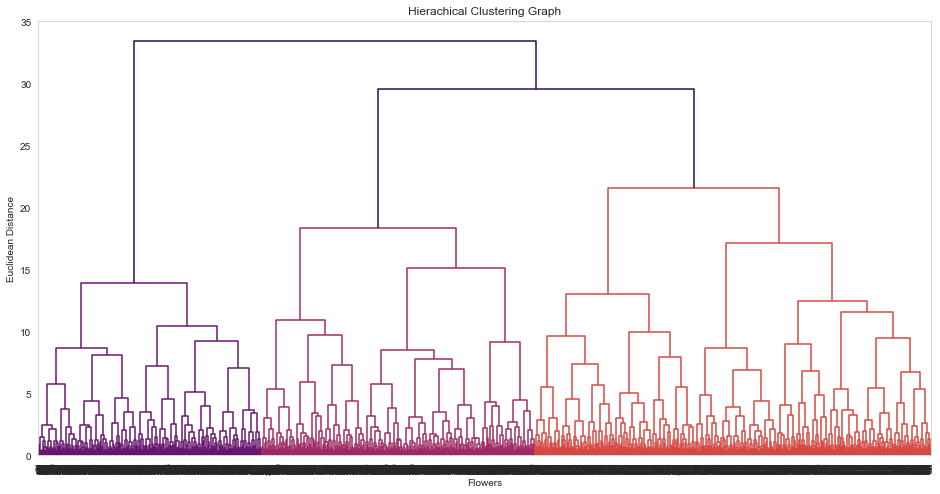

In [88]:
compute_dendrogram(df_scaled, linkage='ward')

- Reveals, k=3!

####  2.4. Deciding Number Of Clusters Using AIC And BIC From GMM

Both AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are metrics that measure the relative prediction errors of different models. The lower the value is, the better the model is.

The Gaussian Mixture Model AIC and BIC scores can help us decide the optimal number of clusters.

In [89]:
def comptute_gmm_metrics(X, min_k, max_k):
    
    aic_score = {} 
    bic_score = {}
    
    max_k = min(max_k, len(X))
    for i in range(min_k, max_k): 
      # Create Gaussian Mixture Model
      gmm = GaussianMixture(n_components=i, random_state=0).fit(X)
      # Get AIC score for the model
      aic_score[i] = gmm.aic(X)
      # Get BIC score for the model
      bic_score[i] = gmm.bic(X)

    # Visualization
    plt.figure(figsize=(12,8))
    plt.plot(list(aic_score.keys()),list(aic_score.values()), label='AIC')
    plt.plot(list(bic_score.keys()),list(bic_score.values()), label='BIC')
    plt.legend(loc='best')
    plt.title('AIC and BIC from GMM')
    plt.xlabel('Number of Clusters')
    plt.ylabel('AIC and BIC values')
    plt.show()
    return

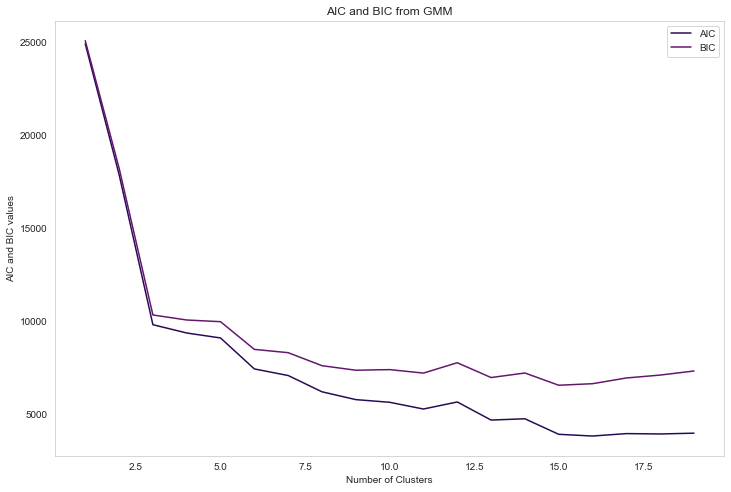

In [91]:
comptute_gmm_metrics(df_scaled, min_k=1, max_k=20)

- Can take k=3 

####  2.5. Deciding Number Of Clusters Using Gap Statistics





In [94]:
def compute_gap_stat(data, nrefs=3, maxClusters=50):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    
    # RESULT:
    # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    k, gapdf = (gaps.argmax() + 1, resultsdf)
    print('According to Gap Stats, Optimal k found is: ', k)
    
    # Visualization:
    plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
    plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
    plt.grid(True)
    plt.xlabel('Cluster Count')
    plt.ylabel('Gap Value')
    plt.title('Gap Values by Cluster Count')
    plt.show()
    
    return

According to Gap Stats, Optimal k found is:  38


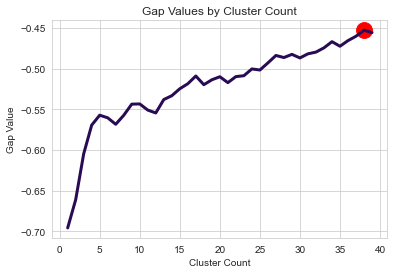

In [97]:
compute_gap_stat(df_scaled, nrefs=3, maxClusters=40)

- Not much clear.

### 3. Fit a K-Means model using optimal K

In [110]:
kmeans = KMeans(
    n_clusters=4, 
    init='k-means++',     # k-means++ --> heurstics method, random --> sampler based
    n_init=10, 
    max_iter=300, 
    tol=1e-04, 
    random_state=7)

kmeans = kmeans.fit(df_scaled)

cluster_ids = kmeans.fit_predict(df_scaled) 

### 4. Visualization

#### 1. PCA (via SVD)

pca.explained variance ratio:
  0.82 0.16 0.01 0.01 0.01 0.00


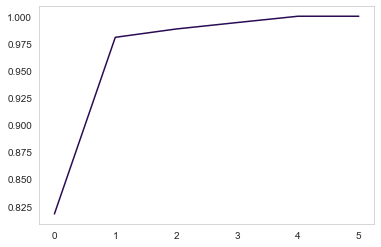

In [111]:
pca = PCA()

# fit only features (no label info)
pca_data = pca.fit_transform(df)

# store principal components
pca_data = pd.DataFrame(pca_data)
pca_data.columns = ["PC_%s" % i for i in range(1, len(df.columns)+1)]

# check proportion of variance explained by these components
print("pca.explained variance ratio:\n ", " ".join(map("{:.2f}".format, pca.explained_variance_ratio_)))
plt.plot(np.cumsum(pca.explained_variance_ratio_));

- PC1 explains about 82% of variability in the data
- PC1 and PC2 together explain about 98% variability in the data

In [112]:
pca_data.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,-7.177875,8.763586,1.361510,-1.107555,0.514804,-0.002736
1,-10.848233,-7.354201,0.243582,1.701827,-1.334084,0.001359
2,-10.934529,6.058349,0.962290,1.254643,1.802970,0.017713
3,-9.512339,8.888690,0.942949,0.157453,0.025676,0.001326
4,0.174162,2.735380,1.685245,1.225438,-0.943739,-0.015133


##### Predict Cluster labels

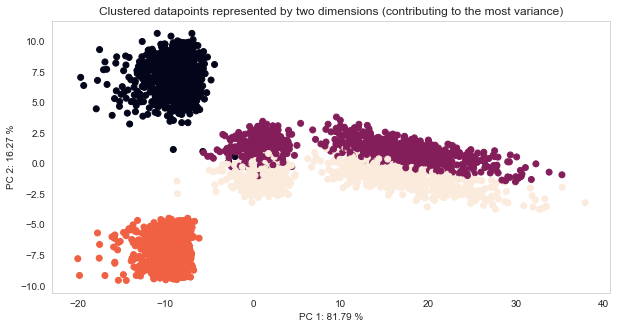

In [113]:
# viz using two PCs explanining about 98% variance in data

plt.figure(figsize=(10,5))
plt.scatter(pca_data["PC_1"], pca_data["PC_2"], c=cluster_ids)
plt.title("Clustered datapoints represented by two dimensions (contributing to the most variance)")
plt.xlabel("PC 1: {:.2f}".format(pca.explained_variance_ratio_[0] * 100) + " %")
plt.ylabel("PC 2: {:.2f}".format(pca.explained_variance_ratio_[1] * 100) + " %")
plt.show()

- Density based methods should do better on this.

#### 2. t-SNE

Using t-SNE we can reduce our 768 high dimensional features vector to 2 dimensions!

By using the 2 dimensions as x,y coordinates, the body_text can be plotted. t-SNE will attempt to preserve the relations of the higher dimensional data as closely as possible when shrunk to 2D. The similar article will thus be in closer proximity to each other.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.004s...
[t-SNE] Computed neighbors for 4000 samples in 0.397s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.271953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.088409
[t-SNE] KL divergence after 1000 iterations: 1.321164


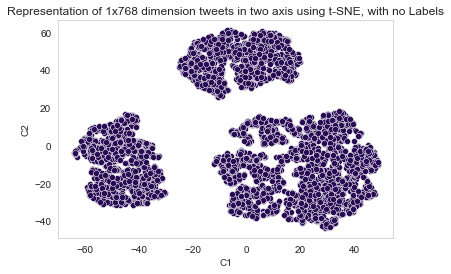

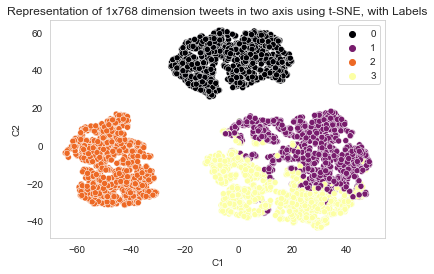

In [117]:
# fit a t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(df_scaled)

# predicted dimensions
tsne_df = pd.DataFrame({"C1": X_embedded[:,0], "C2": X_embedded[:,1]})

#### t-SNE without labels
sns.scatterplot(x="C1", y="C2", data=tsne_df, palette='inferno')
plt.title('Representation of 1x768 dimension tweets in two axis using t-SNE, with no Labels')
plt.show()

#### t-SNE with k-Means predicted cluster ids (i.e. total clusters = 4)
sns.scatterplot(x="C1", y="C2", data=tsne_df, hue=cluster_ids, legend='full', palette='inferno')
plt.title('Representation of 1x768 dimension tweets in two axis using t-SNE, with Labels')
plt.show()

---
---

# 3. Hirerachial Clustering

It's a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:

- `Agglomerative`: This method is derived from AGNES algorithm, or a "bottom-up" approach, where each datapoint starts with its own cluster, and eventually pairs of clusters are merged as one moves up the hierarchy.



- `Divisive` : This method is derived from DIANA algorithm, or a "top-down" approach, where all datapoints start in one mega cluster, and eventually splits into smaller ones. as one moves down the hierarchy.

In general, the merges and splits are determined in a greedy manner. The results of hierarchical clustering are usually presented in a dendrogram.

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

## 3.1. Agglomerative

PROS: We don’t need to specify the number of clusters unlike in K-Means.

CONS: Much slower than K-Means, performance is $𝑂(𝑛^3)$

`Algorithm`

- Step 1. At the start, consider each data point as one cluster. Therefore, the number of clusters at the start will be **n**, while $n$ is an integer representing the number of data points.



- Step 2. Compute the proximity matrix for pair-wise distances using one of the **linkage methods**. The linkage methods work by calculating the distances between all objects. Then the closest pair of clusters are combined into a single cluster, reducing the number of clusters remaining. The process is then repeated until there is only a single cluster left. For text or other non-numeric data, metrics such as the Hamming distance, Levenshtein distance and cosine distance are often used. Types of linkage:
    - 2.1. Single Linkage
    - 2.2. Complete Linkage
    - 2.3. Centroid Linkage
    - 2.4. Ward’s Linkage
    - 2.5. Average Linkage
    
    Single Linkage:

    Two clusters with the ***closest minimum distance*** are merged. 

    <img src="Data/img/single.png" width="250" height="250">

    Complete Linkage:

    Two clusters with the ***closest maximum distance*** are merged. 

    <img src="Data/img/complete.png" width="250" height="250">

    Centroid Linkage:

    Two clusters with the ***lowest centroid distance*** are merged. 

    <img src="Data/img/centroid.png" width="250" height="250">

    Ward Linkage:

    For Ward’s linkage, two clusters are merged based on their ***error sum of square (ESS)*** values. The two clusters with the lowest ESS are merged.

    Average Linkage:

    Average linkage method uses the ***average pair-wise proximity*** among all pairs of objects in different clusters. Clusters are merged based on their lowest average distances.
    

- Step 3. Form a cluster by joining the two closest data points resulting in **n-1** clusters. Similarly, form more clusters by joining the two closest clusters resulting in **n-2** clusters.


- Step 4. Finally, all the clusters are merged together and form a single cluster.


- Step 5. The point of doing all this is to demonstrate the way hierarchical clustering works, it maintains a memory of how we went through this process and that memory is stored in **Dendrogram.** A Dendrogram is a tree-like diagram that records the sequences of merges or splits.

<img src="Data/img/dendrogram1.png" width="600" height="400">
<img src="Data/img/dendrogram2.png" width="600" height="400">



Stopping with a distance threshold:
- You cut the dendrogram tree with a horizontal line at a height where the line can traverse the maximum distance up and down without intersecting the merging point. E.g. L3 can traverse maximum distance up and down without intersecting the merging points. So we draw a horizontal line and the number of verticle lines it intersects is the optimal number of clusters.

<img src="Data/img/dendrogram3.png" width="400" height="400">

## Agglomerative by Hand

In [142]:
data = pd.DataFrame({"UID": ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9'],
                   "X": [3,5,6,2,7,2,4,3,5], 
                   "Y": [9,7,4,8,3,6,3,8,8]})

df = data[:]
df.set_index('UID', inplace=True)
df

,X,Y
UID,,
A1,3,9
A2,5,7
A3,6,4
A4,2,8
A5,7,3
A6,2,6
A7,4,3
A8,3,8
A9,5,8


### 1. Each point starts as a cluster of its own

In [143]:
features = ['X', 'Y']   # could be more than 2

df['cluster_ids'] = [i for i in range(len(df))]
df

,X,Y,cluster_ids
UID,,,
A1,3,9,0
A2,5,7,1
A3,6,4,2
A4,2,8,3
A5,7,3,4
A6,2,6,5
A7,4,3,6
A8,3,8,7
A9,5,8,8


### 2. Compute Proximity Matrix

$Distance\_Matrix \space = \space distance\_matrix(X, Y, \space p = Minkowski\_p_{norm})$

In [144]:
proxy_mat = pd.DataFrame(distance_matrix(df[features].values, df[features].values, p=2), index=df.index, columns=df.index)
proxy_mat

UID,A1,A2,A3,A4,A5,A6,A7,A8,A9
UID,,,,,,,,,
A1,0.000000,2.828427,5.830952,1.414214,7.211103,3.162278,6.082763,1.000000,2.236068
A2,2.828427,0.000000,3.162278,3.162278,4.472136,3.162278,4.123106,2.236068,1.000000
A3,5.830952,3.162278,0.000000,5.656854,1.414214,4.472136,2.236068,5.000000,4.123106
A4,1.414214,3.162278,5.656854,0.000000,7.071068,2.000000,5.385165,1.000000,3.000000
A5,7.211103,4.472136,1.414214,7.071068,0.000000,5.830952,3.000000,6.403124,5.385165
A6,3.162278,3.162278,4.472136,2.000000,5.830952,0.000000,3.605551,2.236068,3.605551
A7,6.082763,4.123106,2.236068,5.385165,3.000000,3.605551,0.000000,5.099020,5.099020
A8,1.000000,2.236068,5.000000,1.000000,6.403124,2.236068,5.099020,0.000000,2.000000
A9,2.236068,1.000000,4.123106,3.000000,5.385165,3.605551,5.099020,2.000000,0.000000


### 3. Assign same cluster id to closest points

To use `np.argmin`, `np.argmax` on $n\times n$ dimesnional array, use: 

$numpy.unravel\_index(\space numpy.argmin(array), \space\space array.shape)$

In [145]:
# to use np.argmin, np.argmax
# replacing diagonal distances (abs zeros) with a big number
min_points = np.unravel_index(np.argmin(proxy_mat.replace(0.00000, np.inf)), proxy_mat.shape)

closest_points = proxy_mat.index[min_points[0]], proxy_mat.columns[min_points[1]]
print("Minimum l2 distance found for {} equal to: {}".format(closest_points, proxy_mat.iloc[min_points]))

Minimum l2 distance found for ('A1', 'A8') equal to: 1.0


### 4. Choose a linkage and merge clusters

In [151]:
# choosing average linkage
# i.e. for points A1 and A8, the new combined value will be computed by averaging values of A1 and A8
# we could choose max value, min value or centroid values

avg_linkage = df.loc[list(closest_points)][features].mean(axis=0)
common_cluster_id = df.loc[list(closest_points)]['cluster_ids'].min()

for point in closest_points:
    df.loc[point] = avg_linkage.tolist() + [common_cluster_id]
    
df

,X,Y,cluster_ids
UID,,,
A1,3.0,8.5,0
A2,5.0,7.0,1
A3,6.0,4.0,2
A4,2.0,8.0,3
A5,7.0,3.0,4
A6,2.0,6.0,5
A7,4.0,3.0,6
A8,3.0,8.5,0
A9,5.0,8.0,8


- A1 and A8 have been assigned same cluster id, and average values of X and Y have been chosen as new values for both of them

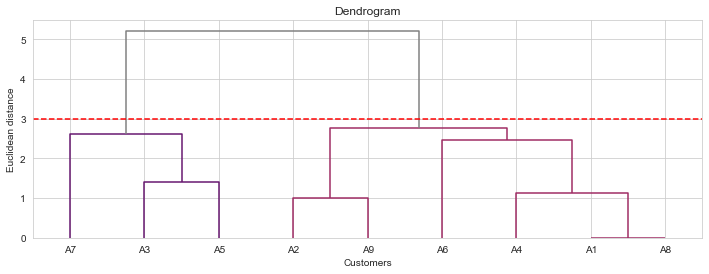

In [160]:
# simple dendrogram

plt.figure(figsize=(12,4))
link = linkage(df[['X','Y']], method = 'average')
dendrogrm = dendrogram(link, above_threshold_color="grey", color_threshold=3, leaf_font_size=10, labels=df.index.tolist())
plt.axhline(y=3, color='r', linestyle='--')
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

- The bottom labels are nothing but the samples. A1 and A8 were merged in previous step, and thus a smudge line.


- Note: For large number of samples, it wouldn't be possible to visualize all the branches (or clades), so $dendrogram()$ has an option of truncating the clades for a given order $p$


- dendrogram(..., truncate_mode=truncate_mode, p=p)

##### Effect of truncate mode and p

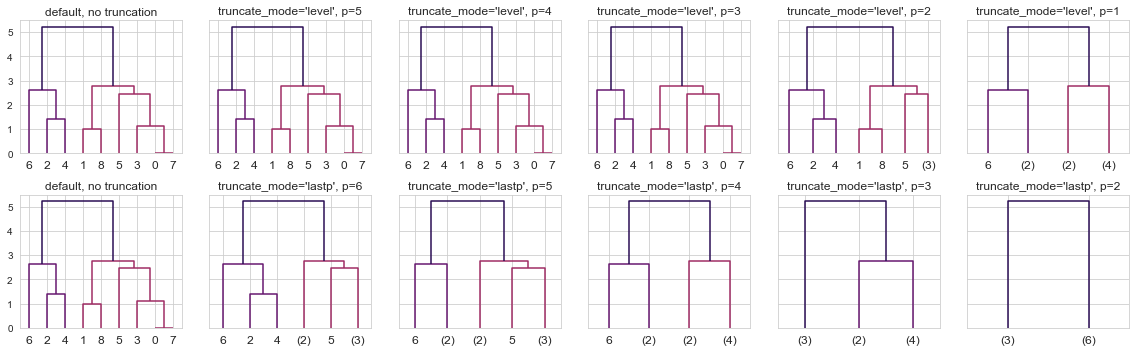

In [124]:
np.random.seed(11)
fig, ax_rows = plt.subplots(ncols=6, nrows=2, sharey=True, figsize=(16, 5))
for ax_row, truncate_mode in zip(ax_rows, ['level', 'lastp']):
    dendrogram(link, ax=ax_row[0])
    ax_row[0].set_title('default, no truncation')
    for ind, ax in enumerate(ax_row[1:]):
        if truncate_mode == 'level':
            p = len(ax_row) - ind - 1
        else:
            p = len(ax_row) - ind
        dendrogram(link, truncate_mode=truncate_mode, p=p, ax=ax)
        ax.set_title(f"truncate_mode='{truncate_mode}', p={p}")
plt.tight_layout()
plt.show()

#### Distance Threshold from Dendrogram for optimal number of clusters

<img src="Data/img/dendrogram4.png" width="450" height="250">
<img src="Data/img/dendrogram5.png" width="450" height="250">

### 5. Repeat 2,3,4 Steps

- We would need to repeat the steps, from computing a new proxmity matrix, to merging closest clusters based on average linkage (or any chosen linkage)

---

## Agglomerative using sklearn

#### Imports

In [7]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, fcluster

#### Dataset

In [248]:
df = pd.read_csv("data_numerical_6Features.csv")
print(df.shape)
df.head()

(4000, 6)


,x1,x2,x3,x4,x5,x6
0,1.868873,-10.463549,0.674638,0.912393,-0.003039,-2.202443
1,-0.137840,5.363186,-0.444914,4.125290,0.002185,-6.643935
2,1.051263,-7.977121,-1.926635,1.195411,0.017575,-6.092424
3,1.426620,-10.728448,-0.062891,2.053938,0.001306,-4.519171
4,1.841122,-4.068528,-0.493864,3.354350,-0.014658,4.857383


#### Normalize

In [249]:
scaler = StandardScaler() 
scaled_data = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(normalize(scaled_data))
df_scaled.columns = df.columns
df_scaled

,x1,x2,x3,x4,x5,x6
0,0.590843,-0.637630,0.174595,-0.395628,-0.108163,-0.213607
1,-0.044665,0.466394,-0.234247,0.775373,0.080312,-0.343450
2,0.264805,-0.369126,-0.633375,-0.232023,0.515914,-0.269182
3,0.527447,-0.768504,-0.116626,0.034097,0.059383,-0.336022
4,0.585551,-0.186709,-0.261405,0.516079,-0.536189,0.010064
...,...,...,...,...,...,...
3995,0.624885,-0.028211,-0.034420,-0.177925,-0.250167,0.716447
3996,-0.480740,0.188995,0.176555,-0.484903,0.216449,0.648088
3997,-0.454434,0.125315,0.236322,0.171190,0.761901,0.334871
3998,-0.390336,0.091263,0.774678,-0.386411,0.079782,0.288971


#### Dendrogram

NOTE:- Running a dendrogram on large datasets is not advised, however, to optmize memory and space consumption, use a $truncate\_mode$


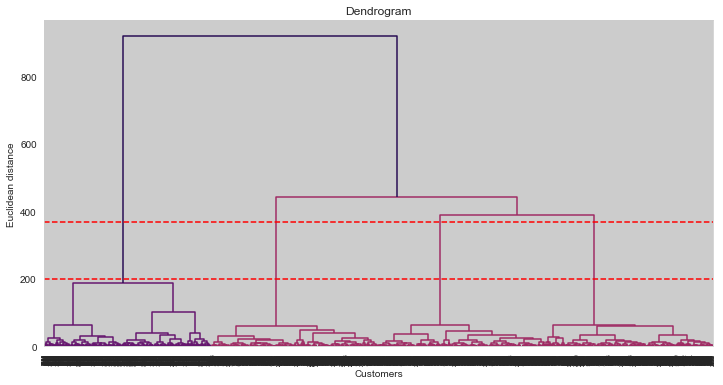

In [251]:
plt.figure(figsize=(12,6))
link = linkage(df, method = 'ward')
dendrogrm = dendrogram(link)
#dendrogrm = dendrogram(link, truncate_mode='level', p=5)
plt.axhline(y=200, color='r', linestyle='--')
plt.axhline(y=370, color='r', linestyle='--')
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

On Mac M1 chip 2022 model, 
- Plotting the dendrogram with any truncate mode on 4000 samples took 8 mins.
- Plotting the dendrogram with a truncate mode with p=5, took <1 min
- Plotting the dendrogram with a truncate mode with p=10, took 2 mins


Seems, k is 4 for most of the range(indicated by orange dotted lines)

In [244]:
hclust = AgglomerativeClustering(n_clusters=None, distance_threshold=20, affinity='euclidean', linkage='ward', compute_distances=True)  
hclust.fit(df_scaled)

df['Cluster_IDs'] = hclust.fit_predict(df_scaled)

In [245]:
df.Cluster_IDs.value_counts()

0    4000
Name: Cluster_IDs, dtype: int64

----
----

# 4. Density Based Clustering


Two types of Density clustering methods:

- 1. DBSCAN
- 2. HDBSCAN

<img src="Data/img/dbs1.png" width="450" height="250">
<img src="Data/img/dbs2.png" width="450" height="250">

## 4.1. DBSCAN


DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It belongs to the unsupervised learning family of clustering algorithms.


When it comes to clustering, usually K-means or Hierarchical clustering algorithms are more popular. But they work well only when the clusters are simple to detect. They will not produce good results when the clusters have complex shapes or structures and this is where the DBSCAN algorithm gets the upper hand.

DBSCAN is a density-based clustering algorithm that assumes that clusters are dense regions in space that are separated by regions having a lower density of data points. Here, the ‘densely grouped’ data points are combined into one cluster. We can identify clusters in large datasets by observing the local density of data points.


- **Epsilon Value (eps)**: 
    Epsilon is the radius of the circle around a data point such that all other data points that fall inside the circle are considered as neighborhood points. In other words, two points are considered to be neighbors if the distance between them is less than or equal to eps.
    
    If the eps value is extremely small, then most of the points may not lie in the neighborhood and will be treated as outliers. This will result in bad clustering as most of the points fail to satisfy the minimum no. of points required to create a dense region.
    
    On the other hand, if an extremely high value is chosen, then the majority of data points will remain in the same cluster. This will again create bad clustering where multiple clusters may end up merging due to the high value of epsilon.
    
    Ideally, we must choose the eps value based on the distance of the dataset (using k-distance graph), however, normally small eps values are preferred.



- **Minimum Points minPts**:
    In DBSCAN minPts is the minimum number of data points that should be there in the region to define the cluster. You can choose the value of minPts based on your domain knowledge. But if you lack domain knowledge a good reference point is to have minPts ≥ D + 1 where D is the dimension of the dataset.

    It is recommended to keep the value for the minPts at least 3, but for larger data sets, a greater minPts value should be chosen, especially if it has many outliers.

#### Imports

In [8]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

#### Dataset

In [120]:
df = pd.read_csv("Data/data_numerical_6Features.csv")
print(df.shape)
df.head()

(4000, 6)


,x1,x2,x3,x4,x5,x6
0,1.868873,-10.463549,0.674638,0.912393,-0.003039,-2.202443
1,-0.137840,5.363186,-0.444914,4.125290,0.002185,-6.643935
2,1.051263,-7.977121,-1.926635,1.195411,0.017575,-6.092424
3,1.426620,-10.728448,-0.062891,2.053938,0.001306,-4.519171
4,1.841122,-4.068528,-0.493864,3.354350,-0.014658,4.857383


#### Normalize

In [121]:
scaler = StandardScaler() 
scaled_data = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(normalize(scaled_data))
df_scaled.columns = df.columns
df_scaled

,x1,x2,x3,x4,x5,x6
0,0.590843,-0.637630,0.174595,-0.395628,-0.108163,-0.213607
1,-0.044665,0.466394,-0.234247,0.775373,0.080312,-0.343450
2,0.264805,-0.369126,-0.633375,-0.232023,0.515914,-0.269182
3,0.527447,-0.768504,-0.116626,0.034097,0.059383,-0.336022
4,0.585551,-0.186709,-0.261405,0.516079,-0.536189,0.010064
...,...,...,...,...,...,...
3995,0.624885,-0.028211,-0.034420,-0.177925,-0.250167,0.716447
3996,-0.480740,0.188995,0.176555,-0.484903,0.216449,0.648088
3997,-0.454434,0.125315,0.236322,0.171190,0.761901,0.334871
3998,-0.390336,0.091263,0.774678,-0.386411,0.079782,0.288971


#### Visualize original data

- PCA works better with original data (unscaled or touched)
- t-SNE works well with scaled data

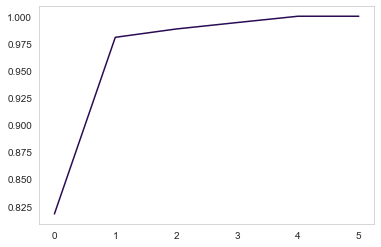

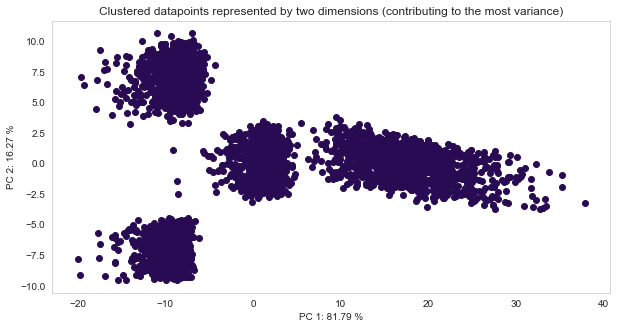

In [130]:
# PCA (2 components oon original data without scaling)
pca = PCA()
pca_data = pca.fit_transform(df)
pca_data = pd.DataFrame(pca_data)
pca_data.columns = ["PC_%s" % i for i in range(1, len(df.columns)+1)]
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.figure(figsize=(10,5))
plt.scatter(pca_data["PC_1"], pca_data["PC_2"])
plt.title("Clustered datapoints represented by two dimensions (contributing to the most variance)")
plt.xlabel("PC 1: {:.2f}".format(pca.explained_variance_ratio_[0] * 100) + " %")
plt.ylabel("PC 2: {:.2f}".format(pca.explained_variance_ratio_[1] * 100) + " %")
plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.393s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.271953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.113358
[t-SNE] KL divergence after 1000 iterations: 1.327372


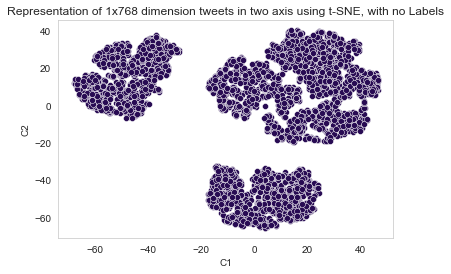

In [127]:
# t-SNE (2 components on scaled data)
tsne = TSNE(n_components=2, verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(df_scaled)
tsne_df = pd.DataFrame({"C1": X_embedded[:,0], "C2": X_embedded[:,1]})
sns.scatterplot(x="C1", y="C2", data=tsne_df, palette='inferno')
plt.title('Representation of 1x768 dimension tweets in two axis using t-SNE, with no Labels')
plt.show()

#### Algorithm

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.004s...
[t-SNE] Computed neighbors for 4000 samples in 0.392s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.271953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.084167
[t-SNE] KL divergence after 1000 iterations: 1.321778


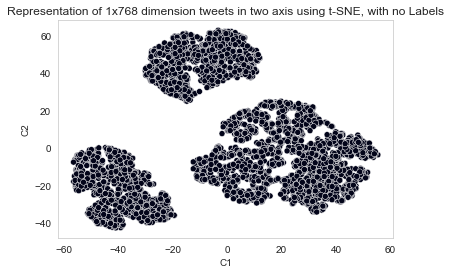

In [134]:
# DBSCAN without any parameter optimization and see the results.
dbscan = DBSCAN()
dbscan.fit(df_scaled)
dbscan_ids = dbscan.labels_ 

# Number of Clusters
N_clus = len(set(dbscan_ids))-(1 if -1 in dbscan_ids else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_ids).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
# print('v_measure =', v_measure_score(y, labels))

# Plotting resulting clusters using t-SNE reduced 2 dimensions:
tsne = TSNE(n_components=2, verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(df_scaled)
tsne_df = pd.DataFrame({"C1": X_embedded[:,0], "C2": X_embedded[:,1]})
sns.scatterplot(x="C1", y="C2", data=tsne_df, c=dbscan_ids, palette='inferno')
plt.title('t-SNE Analysis in two axis using t-SNE, with no Labels')
plt.show()

#### Finding Optimal k

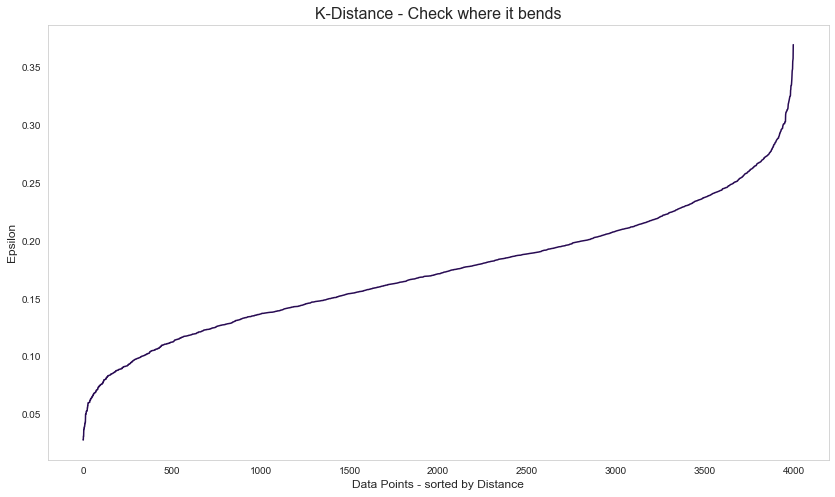

In [138]:
nearest_neighbors = NearestNeighbors(n_neighbors=20)
neighbors = nearest_neighbors.fit(df_scaled)

distances, indices = neighbors.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(14,8))
plt.plot(distances)
plt.title('K-Distance - Check where it bends',fontsize=16)
plt.xlabel('Data Points - sorted by Distance',fontsize=12)
plt.ylabel('Epsilon',fontsize=12)
plt.show()

##### Final model

Estimated no. of clusters: 23
Estimated no. of noise points: 3182
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.002s...
[t-SNE] Computed neighbors for 4000 samples in 0.345s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.271953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.185051
[t-SNE] KL divergence after 1000 iterations: 1.337924


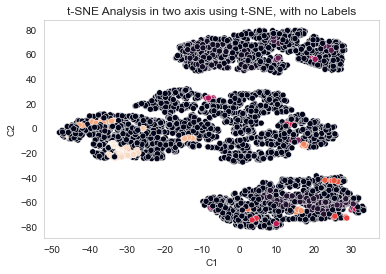

In [140]:
# final DBSCAN model....
dbscan_cluster = DBSCAN(eps=0.26, min_samples=10)
dbscan_cluster.fit(df_scaled)
labels = dbscan_cluster.labels_

# Number of Clusters
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(labels).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Plotting resulting clusters using t-SNE reduced 2 dimensions:
tsne = TSNE(n_components=2, verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(df_scaled)
tsne_df = pd.DataFrame({"C1": X_embedded[:,0], "C2": X_embedded[:,1]})
sns.scatterplot(x="C1", y="C2", data=tsne_df, c=labels, palette='inferno')
plt.title('t-SNE Analysis in two axis using t-SNE, with no Labels')
plt.show()

----

## 4.2. HDBSCAN

HDBSCAN is one of the most popular and more recent algorithm in clustering. And as the name suggests, this clustering algorithm is being derived or extended from the DBSCAN algorithm. In other words, it overcomes some of its limitations.

**One of the key limitations of the DBSCAN is the tuning process for the parameters i.e Epsilon and Min Points. It involves a lot of trials to reach out and obtain its optimum values for a particular dataset.**


- HDBSCAN overcomes these limitations and do an amazing job on challenging clustering tasks.


- Moreover, the HDBSCAN also overcomes one of the key limitations of the hierarchical clustering. One of the limitations in the hierarchical clustering is that we aren’t always sure where to put the thresholds in the Dendrogram.


- It is a density-based clustering algorithm that is particularly useful for handling datasets with varying densities and clusters of different sizes and shapes. It is implemented in the python library hdbscan.

#### Imports

In [9]:
import hdbscan

#### Dataset

In [144]:
df = pd.read_csv("Data/data_numerical_6Features.csv")
print(df.shape)
df.head()

(4000, 6)


,x1,x2,x3,x4,x5,x6
0,1.868873,-10.463549,0.674638,0.912393,-0.003039,-2.202443
1,-0.137840,5.363186,-0.444914,4.125290,0.002185,-6.643935
2,1.051263,-7.977121,-1.926635,1.195411,0.017575,-6.092424
3,1.426620,-10.728448,-0.062891,2.053938,0.001306,-4.519171
4,1.841122,-4.068528,-0.493864,3.354350,-0.014658,4.857383


#### Normalize

In [145]:
scaler = StandardScaler() 
scaled_data = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(normalize(scaled_data))
df_scaled.columns = df.columns
df_scaled

,x1,x2,x3,x4,x5,x6
0,0.590843,-0.637630,0.174595,-0.395628,-0.108163,-0.213607
1,-0.044665,0.466394,-0.234247,0.775373,0.080312,-0.343450
2,0.264805,-0.369126,-0.633375,-0.232023,0.515914,-0.269182
3,0.527447,-0.768504,-0.116626,0.034097,0.059383,-0.336022
4,0.585551,-0.186709,-0.261405,0.516079,-0.536189,0.010064
...,...,...,...,...,...,...
3995,0.624885,-0.028211,-0.034420,-0.177925,-0.250167,0.716447
3996,-0.480740,0.188995,0.176555,-0.484903,0.216449,0.648088
3997,-0.454434,0.125315,0.236322,0.171190,0.761901,0.334871
3998,-0.390336,0.091263,0.774678,-0.386411,0.079782,0.288971


#### Cluster

In [147]:
# Compute the clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
clusterer.fit(df_scaled)

# Plot the results
# plt.scatter(data[:, 0], data[:, 1], c=clusterer.labels_, cmap='rainbow')
# plt.title("HDBSCAN Clustering")
# plt.show()

HDBSCAN()

---
---

# 5. Clustering for Categorical Data

## KModes

KModes clustering is one of the unsupervised Machine Learning algorithms that is used to cluster categorical variables.


- KMeans uses mathematical measures (distance) to cluster continuous data. The lesser the distance, the more similar our data points are. Centroids are updated by Means.


- But for categorical data points, we cannot calculate the distance. 


- So we go for **KModes algorithm**. It uses the dissimilarities(total mismatches) between the data points. The lesser the dissimilarities the more similar our data points are. It uses Modes instead of means.

https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/?

#### 1. Imports

In [24]:
from kmodes.kmodes import KModes

#### 2. Dataset

In [25]:
df = pd.read_csv("Data/kmodes.csv")
df

,Person,hair_color,eye_color,skin_color
0,P1,blonde,amber,fair
1,P2,brunette,gray,brown
2,P3,red,green,brown
3,P4,black,hazel,brown
4,P5,brunette,amber,fair
5,P6,black,gray,brown
6,P7,red,green,fair
7,P8,black,hazel,fair


#### 3. Find optimal K

For KModes, plot cost for a range of K values. Cost is the sum of all the dissimilarities between the clusters.

Select the K where you observe an elbow-like bend with a lesser cost value.

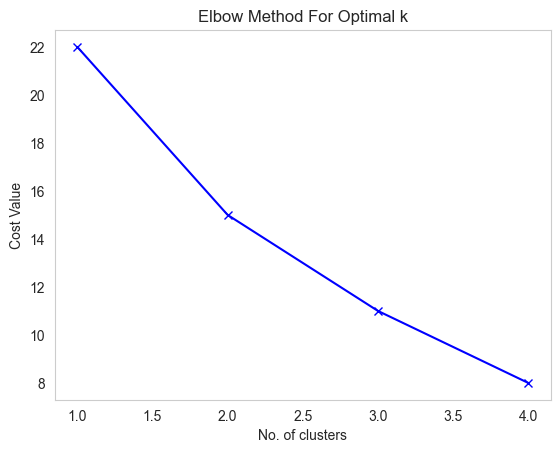

In [26]:
# Elbow curve to find optimal K
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost Value')
plt.title('Elbow Method For Optimal k')
plt.show()

- A bend at K=3 in the above graph indicating 3 is the optimal number of clusters.

#### 4. Build a model with 3 clusters

In [27]:
# Building the model with 3 clusters

kmode = KModes(n_clusters=3, init = "random", n_init = 5, verbose=0)

#### 5. Predict Clusters

In [28]:
# predict

clusters = kmode.fit_predict(df)
df['Cluster_id'] = clusters
df

,Person,hair_color,eye_color,skin_color,Cluster_id
0,P1,blonde,amber,fair,0
1,P2,brunette,gray,brown,0
2,P3,red,green,brown,2
3,P4,black,hazel,brown,1
4,P5,brunette,amber,fair,0
5,P6,black,gray,brown,1
6,P7,red,green,fair,2
7,P8,black,hazel,fair,1


----
----

# 6. Clustering for Mixed Data


Unfortunately, the majority of clustering algorithms can only work with data that exclusively contains either numeric or categorical features. 

The workflow for this article has been inspired by a paper titled “Distance-based clustering of mixed data” by M Van de Velden .et al, that can be found here. These methods are as follows:


https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b

## KMedoids

KMedoids is a clustering alogirthm used for mixed data.

Many distance metrics exist, and one of them is, the ***Gower distance (1971)*** which is used for this kind of dataset.

It is based on a novice `Gower’s distance`. It is used to measure the similarity between two data points that contain both numeric and categorical variables. It simply works by applying different measures of similarity for the each data type. 

The similarity scores for each data type are then combined to create an overall similarity score. The measures used for each data type are as follows:

- **Numerical Variables**: a normalized `Manhattan distance`


- **Categorical Variables**: the variables are first one hot encoded and then the `Jaccard distance` is applied.


- **Ordinal Variables**: the variables are first sorted, then the `Manhattan distance` is applied with an adjustment for ties.



https://medium.com/analytics-vidhya/gowers-distance-899f9c4bd553

#### 1. Imports

In [244]:
import gower
from sklearn_extra.cluster import KMedoids

#### 2. Dataset

In [245]:
# Load dataset
df = pd.read_csv('Data/ObesityData.csv')

df = df[
        ['Gender', 'FoodBetweenMeals', 'History_Overweight',        # categorical -- Jaccard
         'Height', 'Weight',                                        # numeric     -- Manhattan
         'NumMeals'                                                 # ordinal     -- Sort, Manhattan
        ]][:10]

df.index = ["Row_{}".format(i) for i in range(len(df))]
df

,Gender,FoodBetweenMeals,History_Overweight,Height,Weight,NumMeals
Row_0,Female,Med,yes,1.62,64.0,3
Row_1,Female,Med,yes,1.52,56.0,3
Row_2,Male,Med,yes,1.80,77.0,3
Row_3,Male,Med,no,1.80,87.0,3
Row_4,Male,Med,no,1.78,89.8,1
Row_5,Male,Med,no,1.62,53.0,3
Row_6,Female,Med,yes,1.50,55.0,3
Row_7,Male,Med,no,1.64,53.0,3
Row_8,Male,Med,yes,1.78,64.0,3
Row_9,Male,Med,yes,1.72,68.0,3


- This is a sample mixed data.

#### 3. Grower Distance Matrix

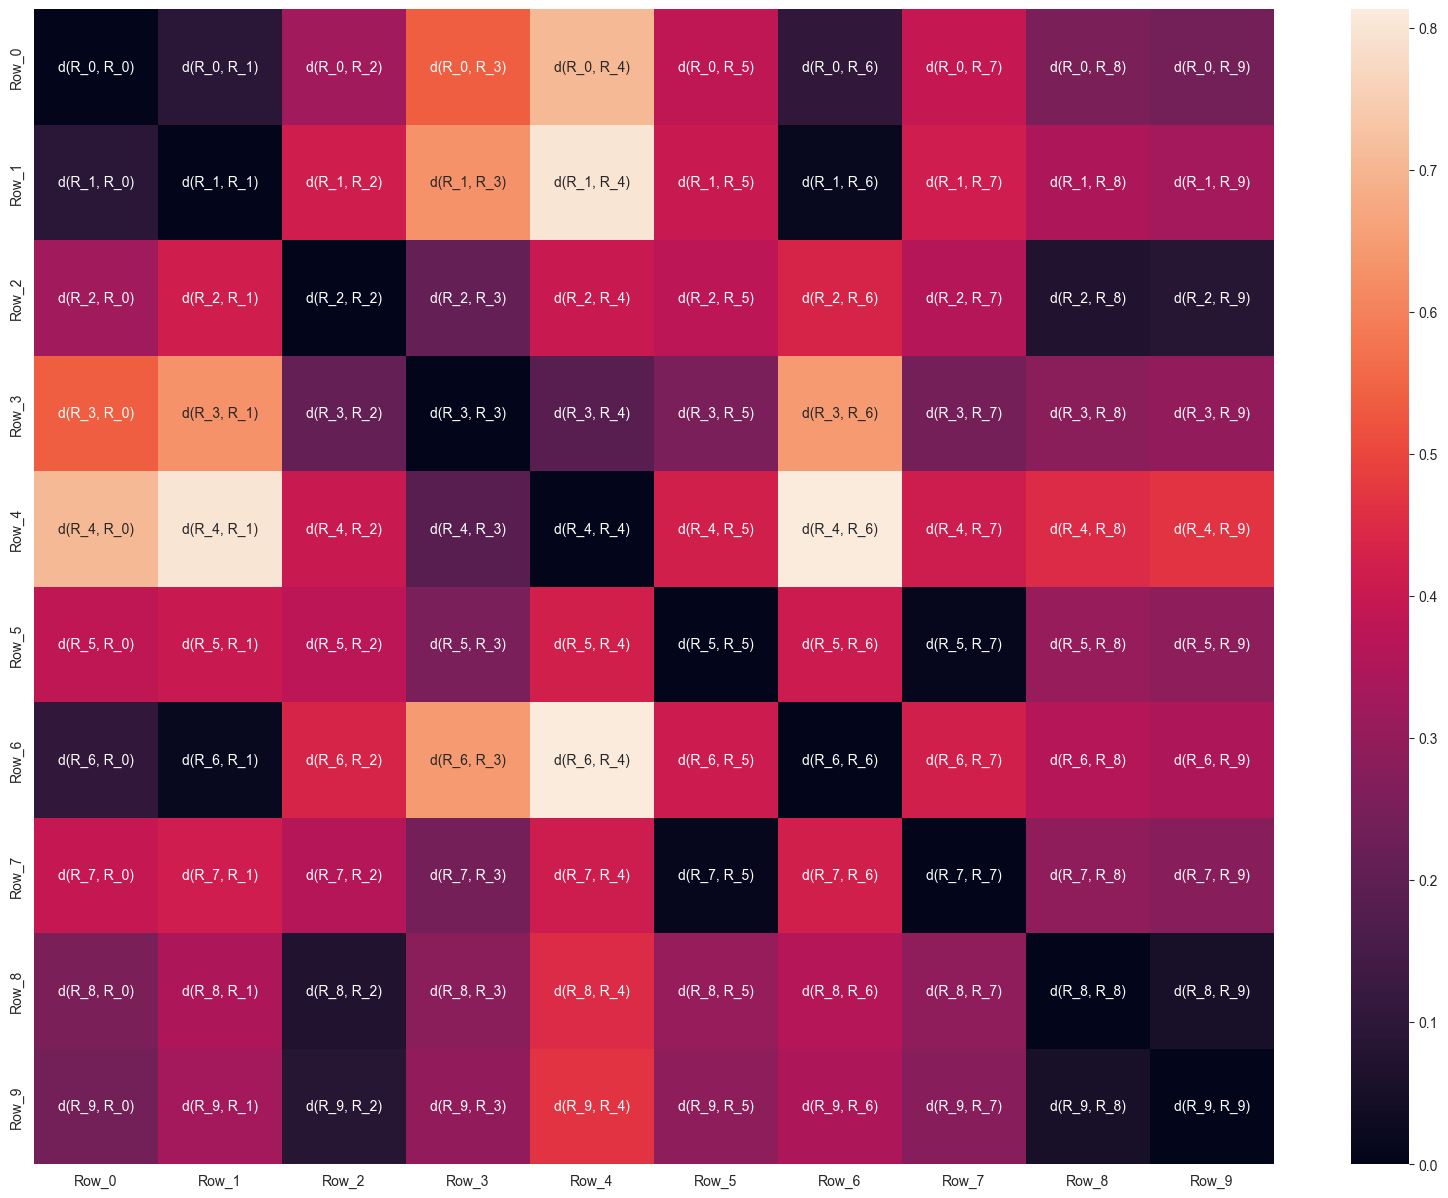

In [234]:
dist_matrix = gower.gower_matrix(df).round(3)
dist_df = pd.DataFrame(dist_matrix, columns=df.index, index=df.index)

# create np.empty, not np.ones or np.zeros!
lab = arr = np.empty((len(df), len(df)), dtype=object)
for i in range(len(df)):
    for j in range(len(df)):
        lab[j][i] = "d(R_{}, R_{})".format(j,i)
        
fig, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(ax = ax, data = dist_df, annot = lab, fmt='')
plt.show()

In [235]:
dist_df

,Row_0,Row_1,Row_2,Row_3,Row_4,Row_5,Row_6,Row_7,Row_8,Row_9
Row_0,0.000,0.092,0.326,0.538,0.706,0.383,0.107,0.394,0.256,0.240
Row_1,0.092,0.000,0.417,0.629,0.798,0.402,0.016,0.414,0.347,0.332
Row_2,0.326,0.417,0.000,0.212,0.402,0.375,0.433,0.364,0.070,0.085
Row_3,0.538,0.629,0.212,0.000,0.190,0.254,0.645,0.243,0.282,0.297
Row_4,0.706,0.798,0.402,0.190,0.000,0.422,0.813,0.411,0.450,0.465
Row_5,0.383,0.402,0.375,0.254,0.422,0.000,0.409,0.011,0.305,0.290
Row_6,0.107,0.016,0.433,0.645,0.813,0.409,0.000,0.420,0.363,0.348
Row_7,0.394,0.414,0.364,0.243,0.411,0.011,0.420,0.000,0.294,0.279
Row_8,0.256,0.347,0.070,0.282,0.450,0.305,0.363,0.294,0.000,0.051
Row_9,0.240,0.332,0.085,0.297,0.465,0.290,0.348,0.279,0.051,0.000


- This is $Row_i \times Row_j$ distance matrix


- $Row_0 \times Row_0$ = 0.0 i.e Distance between Row 1 and Row 1 is zero.


- $Row_0 \times Row_1$ = 0.092 i.e Row 1 and Row 2 are 9 % similar

#### 4. Clustering Model

In [246]:
# found using heuristics, one can try elbow and silhouette cohesion measures for this optimal k
k = 5

# K-Medoids
gower_clusterer = KMedoids(n_clusters=k, 
                           metric='precomputed',
                           method='pam', 
                           init='build', 
                           max_iter=300, 
                           random_state=7)

# Fit on "Grower dist matrix" data of original data
gower_clusterer.fit(dist_matrix)

# predict cluster labels...
df["Cluster_ids"] = gower_clusterer.labels_

#### 5. Viz.

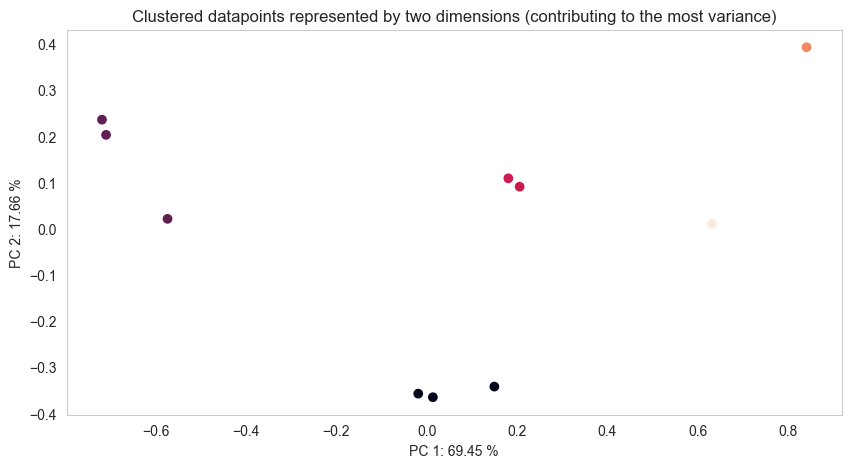

In [247]:
# applying PCA to visualize 6 columns in a 2D Space:

pca = PCA()
pca_data = pca.fit_transform(dist_matrix)     # fit on grower-dist-matrix
pca_data = pd.DataFrame(pca_data) 
plt.figure(figsize=(10,5))
plt.scatter(pca_data[0], pca_data[1], c=df.Cluster_ids.values)
plt.title("Clustered datapoints represented by two dimensions (contributing to the most variance)")
plt.xlabel("PC 1: {:.2f}".format(pca.explained_variance_ratio_[0] * 100) + " %")
plt.ylabel("PC 2: {:.2f}".format(pca.explained_variance_ratio_[1] * 100) + " %")
plt.show()

- As we can see, the number of clusters, could be 8 or 5 based on representation and distance threshold.


- PCA does a great job in clustering these datapoints.

X - X